In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Validate
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import math
from numpy import array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

c:\users\c_benso\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\c_benso\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\c_benso\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


READ ME:

You simply run the code and it should work without changing anything

In [2]:
time_step = 168
num_predict_hours = 168

# Import Data

In [3]:
df1=pd.read_csv('btc_1h.csv')

In [4]:
df1_clean = df1.filter(['close'])

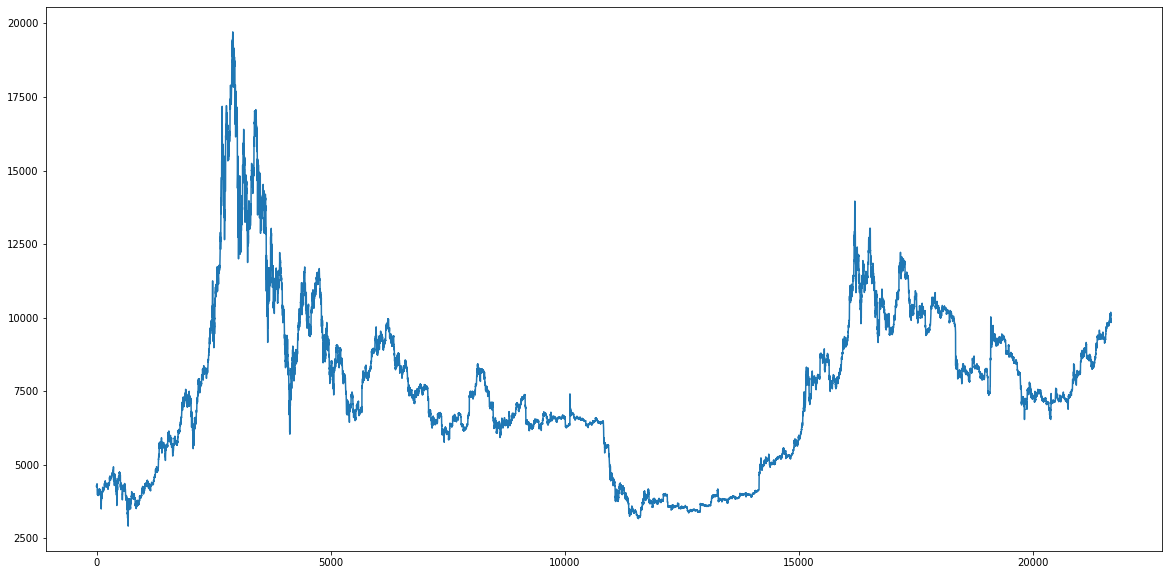

In [5]:
#Visualize data
plt.figure(figsize = (20,10))
plt.plot(df1_clean)

# Normalize data 

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1_clean).reshape(-1,1))

In [7]:
print(df1)

[[0.08144665]
 [0.07888925]
 [0.08031863]
 ...
 [0.41910068]
 [0.41987969]
 [0.41532772]]


# Create train + test data

## Splitting dataset into train and test split

In [8]:
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size

train_data=df1[int(training_size*0.6):training_size,:]
test_data=df1[training_size:len(df1),:1]
valid_data=train_data[int(len(train_data)*0.7):] 

print(training_size,train_data.shape,valid_data.shape,test_data.shape)

17334 (6934, 1) (2081, 1) (4334, 1)


Creating a small dataset for testing

## Convert an array of values into a X and Y format for: training and test

In [9]:
## X being the input values
## Y being the target

def create_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

## Convert dataset to trainning and test data

In [10]:
#Convert the train_data + Test data
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_valid, y_valid = create_dataset(valid_data, time_step)

In [11]:
print("Train")
print(X_train.shape), print(y_train.shape)
print("Test")
print(X_test.shape), print(y_test.shape), 
print("valid")
print(X_valid.shape), print(y_valid.shape)

Train
(6765, 168)
(6765,)
Test
(4165, 168)
(4165,)
valid
(1912, 168)
(1912,)


(None, None)

In [12]:
# Reshape input to [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , 1)
print(X_train.shape)

(6765, 168, 1)


# Create LSTM Model/Hyperparameter Tuner
## If you wish to use the hyperparameter tuner just uncomment the following upto you see "here" - run it once then use those hyperparameters to fit in the next section so it saves time

In [13]:
# from kerastuner.engine.hyperparameters import HyperParameters
# from kerastuner.tuners import RandomSearch
# import time
# EXECUTION_PER_TRIAL = 1

# LOG_DIR = f"{int(time.time())}"

# def build_model(hp):
#     model=Sequential()
#     model.add(LSTM(hp.Int("input_units", min_value = 1, max_value= 30, step = 5), return_sequences=True, input_shape= (X_train.shape[1], 1)))
#     model.add(LSTM(hp.Int("input_units", min_value = 1, max_value= 30, step = 5), return_sequences= False))
#     model.add(Dense(168))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error',optimizer='adam')
#     return model


# tuner = RandomSearch(build_model, objective ='loss', max_trials=10, executions_per_trial=EXECUTION_PER_TRIAL, directory = LOG_DIR)
# tuner.search(x= X_train, y=y_train, epochs =5 , batch_size =512, validation_data = (X_valid, y_valid))

We get the hyperparameters by looking at the summary

In [14]:
# model.summary()

In [15]:
# test_predict=model.predict(X_test,verbose=1)
# test_predict=scaler.inverse_transform(test_predict)

Check the loss vs val_loss to see if it makes sense

In [16]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# model.compile(loss='mean_squared_error',optimizer='adam')


# Here

# Using the optimized hyperparamter

We created a seperate model here to further test the model with optimized hyperparemters instead of needing to rerun the whole tuner, as we already know what are the hyperparameter given by the model.summary().

In [17]:
#You change the hyperparameters with the hyperparameters
from tensorflow.keras.layers import Dropout
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
history=model.fit(X_train, y_train, batch_size=256, epochs=10,validation_data = (X_valid, y_valid),verbose=1)

Epoch 1/10
27/27 [==============================] - 18s 663ms/step - loss: 0.0086 - val_loss: 5.5735e-04
Epoch 2/10
27/27 [==============================] - 15s 559ms/step - loss: 0.0012 - val_loss: 2.1152e-04
Epoch 3/10
27/27 [==============================] - 15s 560ms/step - loss: 7.5657e-04 - val_loss: 2.7749e-04
Epoch 4/10
27/27 [==============================] - 15s 558ms/step - loss: 6.2263e-04 - val_loss: 2.0446e-04
Epoch 5/10
27/27 [==============================] - 15s 563ms/step - loss: 5.4015e-04 - val_loss: 1.9784e-04
Epoch 6/10
27/27 [==============================] - 15s 561ms/step - loss: 4.9171e-04 - val_loss: 2.2159e-04
Epoch 7/10
27/27 [==============================] - 16s 583ms/step - loss: 4.2782e-04 - val_loss: 1.9085e-04
Epoch 8/10
27/27 [==============================] - 15s 567ms/step - loss: 4.4773e-04 - val_loss: 3.7158e-04
Epoch 9/10
27/27 [==============================] - 15s 564ms/step - loss: 4.0192e-04 - val_loss: 2.3204e-04
Epoch 10/10
27/27 [========

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 168, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 31,849
Trainable params: 31,849
Non-trainable params: 0
____________________________________________________

In [19]:
#Predict model
test_predict=model.predict(X_test,verbose=1)

131/131 [==============================] - 6s 44ms/step


# Results

Check val and val_loss to see if is overfitting

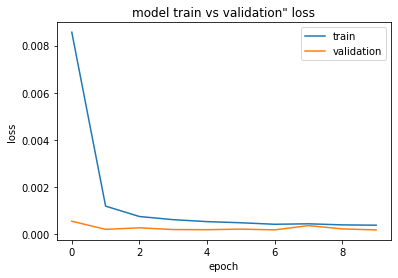

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation" loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
#Reshape so fits in inverse sacler
y_test=y_test.reshape(-1,1)

#Denormalize output so can calculate results
test_predict=scaler.inverse_transform(test_predict)
y_test=scaler.inverse_transform(y_test)

In [22]:
MAE=median_absolute_error(y_test, test_predict)
mse=mean_squared_error(y_test, test_predict)
rmse=sqrt(mean_squared_error(y_test, test_predict))
rsquare=r2_score(y_test,test_predict)
print(MAE,mse,rmse,rsquare)

43.54773437499989 15162.917684961923 123.13779957820394 0.986947549859757


# Plot

IF YOU CHANGE THE TIME STEP (want to look back further) YOU HAVE TO CHANGE THE +{ NUMBER } AT VALID = df1_clean[training_size+337:]

<ipython-input-23-82e7da22a95d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict[: :]


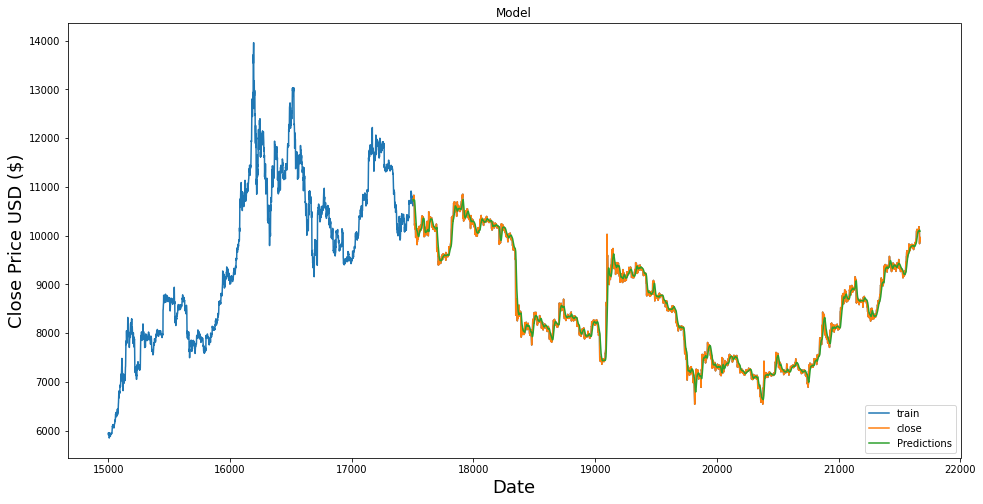

In [23]:
# test_predict2 = pd.DataFrame(test_predict)
# validation['Predictions'] = test_predict2
train=df1_clean[15000:]
valid = df1_clean[training_size+169:]
valid['Predictions'] = test_predict[: :]

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train[['close']])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['train','close', 'Predictions'], loc='lower right')
plt.show()



# Forecasting
## Split data into 7 time period
Take X amount of time_step and predict Y amount of days forward (instead of one) 
on a span of 7 time period

In [24]:
len(test_data)

4334

In [25]:
#How many period do you want to go back? Timesteps* NUMBER OF PERIOD
# for example: we use 168 days to determine 168 days ahead
# and we have a dataset [0:336]
# the data will use 168->336 to forecast 336->504
# but what if we want to predict go back a period before?
# therefore 168*2(number of period) = 336 and we will use 0->168 to predict 168->336

# futher explanation: 
# we are working backwards
# if we want 7 period, w/10 timestep to predict 10 upcoming days on a dataset of 1:100
# [100,99,...91] will be used predict 10 upcoming days (101->111)
# [90...81] will predict the upcoming days (91...100)) (which will be HIDDEN)
# We do this for X amount of period desired

#creates an array x_input with 168 values from the test_data and stores them based on the desired period
#example: [1...100] timestep =10
#1st period = [100...91]
#2nd period = [90...81]

num_period=[1,2,3,4,5,6,7]
x_input=[]
type(len(test_data))
for i in num_period:
    #4334 (length of test data) - 168 (number of timesteps) = 4284
    # 1st period => append(test_data[4334-1*168 : 4334-0*168] => 4166:4334
    # 2nd period => append(test_data[4334-2*168 : 4334-1*168] => 3998:4166
    #... 7 time
    x_input.append(test_data[len(test_data)-int(i*time_step):len(test_data)-((i-1)*time_step)].reshape(1,-1))
    
len(x_input)    
print(x_input)

[array([[0.38427801, 0.38266639, 0.38080641, 0.38310235, 0.38284268,
        0.38188559, 0.38322921, 0.37824961, 0.37787261, 0.37964146,
        0.38053483, 0.38103094, 0.38111075, 0.37929663, 0.37849081,
        0.37957416, 0.38182841, 0.37860516, 0.38012924, 0.37902087,
        0.37832405, 0.37940145, 0.37853369, 0.37876359, 0.37645097,
        0.3724225 , 0.37234865, 0.37305679, 0.37011465, 0.37157023,
        0.37131175, 0.37446592, 0.37559334, 0.37574819, 0.37381674,
        0.37326881, 0.37435693, 0.37223966, 0.37422828, 0.3739031 ,
        0.37554867, 0.37346118, 0.37568744, 0.37641464, 0.37672196,
        0.37863256, 0.37807093, 0.3785194 , 0.37756648, 0.37733718,
        0.385007  , 0.3870927 , 0.38903964, 0.38890265, 0.38870909,
        0.39105923, 0.39569995, 0.39555225, 0.4013049 , 0.4012382 ,
        0.40224353, 0.40341264, 0.39998809, 0.39862065, 0.39496084,
        0.39995831, 0.39688931, 0.40002978, 0.40057413, 0.40011614,
        0.40082606, 0.39961883, 0.40063727, 0.4

In [26]:
#Reshape
count= 0
for i in x_input:
        x_input[count]=i.reshape(-1)
        count+=1

In [27]:
x_input[0]

array([0.38427801, 0.38266639, 0.38080641, 0.38310235, 0.38284268,
       0.38188559, 0.38322921, 0.37824961, 0.37787261, 0.37964146,
       0.38053483, 0.38103094, 0.38111075, 0.37929663, 0.37849081,
       0.37957416, 0.38182841, 0.37860516, 0.38012924, 0.37902087,
       0.37832405, 0.37940145, 0.37853369, 0.37876359, 0.37645097,
       0.3724225 , 0.37234865, 0.37305679, 0.37011465, 0.37157023,
       0.37131175, 0.37446592, 0.37559334, 0.37574819, 0.37381674,
       0.37326881, 0.37435693, 0.37223966, 0.37422828, 0.3739031 ,
       0.37554867, 0.37346118, 0.37568744, 0.37641464, 0.37672196,
       0.37863256, 0.37807093, 0.3785194 , 0.37756648, 0.37733718,
       0.385007  , 0.3870927 , 0.38903964, 0.38890265, 0.38870909,
       0.39105923, 0.39569995, 0.39555225, 0.4013049 , 0.4012382 ,
       0.40224353, 0.40341264, 0.39998809, 0.39862065, 0.39496084,
       0.39995831, 0.39688931, 0.40002978, 0.40057413, 0.40011614,
       0.40082606, 0.39961883, 0.40063727, 0.40161043, 0.40257

In [28]:
#Create a temp_input
temp_input=[]
for i in x_input:
    temp_input.append(i)

## Creates 168 values of each period (7 times)

In [29]:
# demonstrate prediction for next 7 days (168 hours) * 7 periods
lst_output=[]
n_steps=time_step
i=0
final=[]

#First, goes into the else loop
    #creates the timeinput +1 by predicting first timesteps and adding it
    #therefore temp_input>time_step => enters if loop

#Second, inside if 
    #puts the timesteps(number of days to lookback) + 1 to the array 
    #predicts yhat
    #extends and adds into list (lst_output)
    #removes the first [0] by doing [1:]
    #and transform it back to temp_input>timestep
    #continuously going: into this if loop until over i<num_predict_hours
    
#Outside the loop while, reinitializes lst_output to nothing
    #And redo this again until for loop (7days/Number of period desired) is over

#NOTE: It's skipped at 0 because otherwise it would add an empty [] to the final 

for num_period  in range(7):
    print(num_period)
    i=0
    if num_period !=0:
        final.append(lst_output)
    lst_output=[]
    print(lst_output)
    print("lst_output")

    print(final)
    while(i<num_predict_hours):
        if(len(temp_input[num_period])>time_step):
            print("if statement")
            print(len(temp_input[num_period].reshape(-1)))
            print(len(temp_input[num_period]))
            x_input[num_period]=np.array(temp_input[num_period][1:])
            print("{} day input {}".format(i,x_input[num_period]))
            print(x_input[num_period].shape)
            x_input[num_period] = x_input[num_period].reshape((1, n_steps, 1))
            #print(x_input)
            \
            \
            yhat = model.predict(x_input[num_period], verbose=0)
            print("{} day output {}".format(i,yhat))

            temp_input[num_period]=np.append(temp_input[num_period],yhat)

            temp_input[num_period]=temp_input[num_period][1:]

            lst_output=np.append(lst_output,yhat)
            i=i+1
        else:
            print("else")
            print(len(x_input[num_period].reshape(-1)))
            x_input[num_period] = x_input[num_period].reshape((1, n_steps,1))
            yhat = model.predict(x_input[num_period], verbose=0)
            print("this is the output")
            print(yhat[0])
            print("I added it")
            temp_input[num_period]=np.append(temp_input[num_period],yhat)
            print(temp_input[num_period])
            print(len(temp_input[num_period]))
            lst_output=np.append(lst_output,yhat)

            i=i+1
    print("This is the final output")
    print(lst_output)

0
[]
lst_output
[]
else
168
this is the output
[0.4251387]
I added it
[0.38427801 0.38266639 0.38080641 0.38310235 0.38284268 0.38188559
 0.38322921 0.37824961 0.37787261 0.37964146 0.38053483 0.38103094
 0.38111075 0.37929663 0.37849081 0.37957416 0.38182841 0.37860516
 0.38012924 0.37902087 0.37832405 0.37940145 0.37853369 0.37876359
 0.37645097 0.3724225  0.37234865 0.37305679 0.37011465 0.37157023
 0.37131175 0.37446592 0.37559334 0.37574819 0.37381674 0.37326881
 0.37435693 0.37223966 0.37422828 0.3739031  0.37554867 0.37346118
 0.37568744 0.37641464 0.37672196 0.37863256 0.37807093 0.3785194
 0.37756648 0.37733718 0.385007   0.3870927  0.38903964 0.38890265
 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382
 0.40224353 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831
 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883
 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117
 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.406

6 day output [[0.42319712]]
if statement
169
169
7 day input [0.37824961 0.37787261 0.37964146 0.38053483 0.38103094 0.38111075
 0.37929663 0.37849081 0.37957416 0.38182841 0.37860516 0.38012924
 0.37902087 0.37832405 0.37940145 0.37853369 0.37876359 0.37645097
 0.3724225  0.37234865 0.37305679 0.37011465 0.37157023 0.37131175
 0.37446592 0.37559334 0.37574819 0.37381674 0.37326881 0.37435693
 0.37223966 0.37422828 0.3739031  0.37554867 0.37346118 0.37568744
 0.37641464 0.37672196 0.37863256 0.37807093 0.3785194  0.37756648
 0.37733718 0.385007   0.3870927  0.38903964 0.38890265 0.38870909
 0.39105923 0.39569995 0.39555225 0.4013049  0.4012382  0.40224353
 0.40341264 0.39998809 0.39862065 0.39496084 0.39995831 0.39688931
 0.40002978 0.40057413 0.40011614 0.40082606 0.39961883 0.40063727
 0.40161043 0.40257884 0.40379322 0.41131711 0.40649117 0.41126232
 0.40903368 0.4091385  0.40812185 0.40797951 0.4066758  0.40882821
 0.40684852 0.40342456 0.40814746 0.40928799 0.41029392 0.40981507
 

13 day output [[0.42319688]]
if statement
169
169
14 day input [0.37849081 0.37957416 0.38182841 0.37860516 0.38012924 0.37902087
 0.37832405 0.37940145 0.37853369 0.37876359 0.37645097 0.3724225
 0.37234865 0.37305679 0.37011465 0.37157023 0.37131175 0.37446592
 0.37559334 0.37574819 0.37381674 0.37326881 0.37435693 0.37223966
 0.37422828 0.3739031  0.37554867 0.37346118 0.37568744 0.37641464
 0.37672196 0.37863256 0.37807093 0.3785194  0.37756648 0.37733718
 0.385007   0.3870927  0.38903964 0.38890265 0.38870909 0.39105923
 0.39569995 0.39555225 0.4013049  0.4012382  0.40224353 0.40341264
 0.39998809 0.39862065 0.39496084 0.39995831 0.39688931 0.40002978
 0.40057413 0.40011614 0.40082606 0.39961883 0.40063727 0.40161043
 0.40257884 0.40379322 0.41131711 0.40649117 0.41126232 0.40903368
 0.4091385  0.40812185 0.40797951 0.4066758  0.40882821 0.40684852
 0.40342456 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082
 0.40934576 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676


20 day output [[0.42337254]]
if statement
169
169
21 day input [0.37940145 0.37853369 0.37876359 0.37645097 0.3724225  0.37234865
 0.37305679 0.37011465 0.37157023 0.37131175 0.37446592 0.37559334
 0.37574819 0.37381674 0.37326881 0.37435693 0.37223966 0.37422828
 0.3739031  0.37554867 0.37346118 0.37568744 0.37641464 0.37672196
 0.37863256 0.37807093 0.3785194  0.37756648 0.37733718 0.385007
 0.3870927  0.38903964 0.38890265 0.38870909 0.39105923 0.39569995
 0.39555225 0.4013049  0.4012382  0.40224353 0.40341264 0.39998809
 0.39862065 0.39496084 0.39995831 0.39688931 0.40002978 0.40057413
 0.40011614 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884
 0.40379322 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385
 0.40812185 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456
 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576
 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194
 0.41037075 0.4071874  0.40874542 0.411198   0.40993538 0.40971919
 0

26 day output [[0.4235221]]
if statement
169
169
27 day input [0.37305679 0.37011465 0.37157023 0.37131175 0.37446592 0.37559334
 0.37574819 0.37381674 0.37326881 0.37435693 0.37223966 0.37422828
 0.3739031  0.37554867 0.37346118 0.37568744 0.37641464 0.37672196
 0.37863256 0.37807093 0.3785194  0.37756648 0.37733718 0.385007
 0.3870927  0.38903964 0.38890265 0.38870909 0.39105923 0.39569995
 0.39555225 0.4013049  0.4012382  0.40224353 0.40341264 0.39998809
 0.39862065 0.39496084 0.39995831 0.39688931 0.40002978 0.40057413
 0.40011614 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884
 0.40379322 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385
 0.40812185 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456
 0.40814746 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576
 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194
 0.41037075 0.4071874  0.40874542 0.411198   0.40993538 0.40971919
 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306
 0.

33 day output [[0.4236954]]
if statement
169
169
34 day input [0.37381674 0.37326881 0.37435693 0.37223966 0.37422828 0.3739031
 0.37554867 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256
 0.37807093 0.3785194  0.37756648 0.37733718 0.385007   0.3870927
 0.38903964 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225
 0.4013049  0.4012382  0.40224353 0.40341264 0.39998809 0.39862065
 0.39496084 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614
 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322
 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185
 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746
 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623
 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075
 0.4071874  0.40874542 0.411198   0.40993538 0.40971919 0.40868527
 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328
 0.4092195  0.40900688 0.40559126 0.40469968 0.40726065 0.40749174
 0.

39 day output [[0.42384318]]
if statement
169
169
40 day input [0.37554867 0.37346118 0.37568744 0.37641464 0.37672196 0.37863256
 0.37807093 0.3785194  0.37756648 0.37733718 0.385007   0.3870927
 0.38903964 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225
 0.4013049  0.4012382  0.40224353 0.40341264 0.39998809 0.39862065
 0.39496084 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614
 0.40082606 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322
 0.41131711 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185
 0.40797951 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746
 0.40928799 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623
 0.40860844 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075
 0.4071874  0.40874542 0.411198   0.40993538 0.40971919 0.40868527
 0.40977636 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328
 0.4092195  0.40900688 0.40559126 0.40469968 0.40726065 0.40749174
 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184
 

46 day output [[0.42401454]]
if statement
169
169
47 day input [0.3785194  0.37756648 0.37733718 0.385007   0.3870927  0.38903964
 0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0

52 day output [[0.42416018]]
if statement
169
169
53 day input [0.38890265 0.38870909 0.39105923 0.39569995 0.39555225 0.4013049
 0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0

59 day input [0.4012382  0.40224353 0.40341264 0.39998809 0.39862065 0.39496084
 0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.4292

64 day output [[0.4244478]]
if statement
169
169
65 day input [0.39995831 0.39688931 0.40002978 0.40057413 0.40011614 0.40082606
 0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465
 0

70 day output [[0.4245899]]
if statement
169
169
71 day input [0.39961883 0.40063727 0.40161043 0.40257884 0.40379322 0.41131711
 0.40649117 0.41126232 0.40903368 0.4091385  0.40812185 0.40797951
 0.4066758  0.40882821 0.40684852 0.40342456 0.40814746 0.40928799
 0.41029392 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844
 0.40992406 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874
 0.40874542 0.411198   0.40993538 0.40971919 0.40868527 0.40977636
 0.40836128 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195
 0.40900688 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966
 0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465
 0.42675025 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445
 0

77 day output [[0.42475414]]
if statement
169
169
78 day input [0.41126232 0.40903368 0.4091385  0.40812185 0.40797951 0.4066758
 0.40882821 0.40684852 0.40342456 0.40814746 0.40928799 0.41029392
 0.40981507 0.40861082 0.40934576 0.40723623 0.40860844 0.40992406
 0.40821179 0.40942676 0.41080194 0.41037075 0.4071874  0.40874542
 0.411198   0.40993538 0.40971919 0.40868527 0.40977636 0.40836128
 0.40633037 0.40737322 0.41046306 0.4106328  0.4092195  0.40900688
 0.40559126 0.40469968 0.40726065 0.40749174 0.40760966 0.40811113
 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958 0.40942855
 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873
 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761
 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328
 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025
 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445 0.42555612
 0.42678777 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861


84 day output [[0.4249169]]
if statement
169
169
85 day input [0.40684852 0.40342456 0.40814746 0.40928799 0.41029392 0.40981507
 0.40861082 0.40934576 0.40723623 0.40860844 0.40992406 0.40821179
 0.40942676 0.41080194 0.41037075 0.4071874  0.40874542 0.411198
 0.40993538 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037
 0.40737322 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126
 0.40469968 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204
 0.41036955 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634
 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211
 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108
 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338
 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096
 0.4283988  0.42711176 0.42638992 0.42618445 0.42555612 0.42678777
 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474
 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772 0.42513871
 0.

91 day output [[0.42507803]]
if statement
169
169
92 day input [0.40934576 0.40723623 0.40860844 0.40992406 0.40821179 0.40942676
 0.41080194 0.41037075 0.4071874  0.40874542 0.411198   0.40993538
 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547
 0.42395341 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251


97 day output [[0.42521486]]
if statement
169
169
98 day input [0.41080194 0.41037075 0.4071874  0.40874542 0.411198   0.40993538
 0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547
 0.42395341 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251
 0.42313305 0.42313039 0.42313877 0.42315432 0.42317423 0.42319688


103 day output [[0.42535067]]
if statement
169
169
104 day input [0.40971919 0.40868527 0.40977636 0.40836128 0.40633037 0.40737322
 0.41046306 0.4106328  0.4092195  0.40900688 0.40559126 0.40469968
 0.40726065 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955
 0.40959352 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023
 0.41329383 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453
 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238
 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817
 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988
 0.42711176 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094
 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941
 0.41194187 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547
 0.42395341 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251
 0.42313305 0.42313039 0.42313877 0.42315432 0.42317423 0.42319688
 0.42322102 0.42324591 0.42327121 0.42329666 0.42332202 0.4233473

110 day output [[0.4255076]]
if statement
169
169
111 day input [0.4106328  0.4092195  0.40900688 0.40559126 0.40469968 0.40726065
 0.40749174 0.40760966 0.40811113 0.41014204 0.41036955 0.40959352
 0.41041184 0.41041958 0.40942855 0.41225634 0.41157023 0.41329383
 0.41351895 0.41230219 0.41354873 0.41320211 0.41664453 0.41656056
 0.41547601 0.41797147 0.41808761 0.42486108 0.42716238 0.42768172
 0.42748935 0.42934219 0.42833328 0.42619338 0.42896817 0.42824931
 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988  0.42711176
 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094 0.43076442
 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187
 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547 0.42395341
 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305
 0.42313039 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102
 0.42324591 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254
 0.42339763 0.42342266 0.42344755 0.42347243 0.42349729 0.4235221

118 day output [[0.42568508]]
if statement
169
169
119 day input [0.40811113 0.41014204 0.41036955 0.40959352 0.41041184 0.41041958
 0.40942855 0.41225634 0.41157023 0.41329383 0.41351895 0.41230219
 0.41354873 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147
 0.41808761 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219
 0.42833328 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465
 0.42675025 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445
 0.42555612 0.42678777 0.42924094 0.43076442 0.43269647 0.42966678
 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068 0.41987969
 0.41532772 0.42513871 0.42443547 0.42395341 0.42362857 0.42341483
 0.42327896 0.42319712 0.42315251 0.42313305 0.42313039 0.42313877
 0.42315432 0.42317423 0.42319688 0.42322102 0.42324591 0.42327121
 0.42329666 0.42332202 0.42334735 0.42337254 0.42339763 0.42342266
 0.42344755 0.42347243 0.42349729 0.42352211 0.42354691 0.42357171
 0.42359641 0.42362121 0.42364594 0.42367059 0.42369539 0.423720

125 day output [[0.42583883]]
if statement
169
169
126 day input [0.41225634 0.41157023 0.41329383 0.41351895 0.41230219 0.41354873
 0.41320211 0.41664453 0.41656056 0.41547601 0.41797147 0.41808761
 0.42486108 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328
 0.42619338 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025
 0.4275096  0.4283988  0.42711176 0.42638992 0.42618445 0.42555612
 0.42678777 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861
 0.42711474 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772
 0.42513871 0.42443547 0.42395341 0.42362857 0.42341483 0.42327896
 0.42319712 0.42315251 0.42313305 0.42313039 0.42313877 0.42315432
 0.42317423 0.42319688 0.42322102 0.42324591 0.42327121 0.42329666
 0.42332202 0.42334735 0.42337254 0.42339763 0.42342266 0.42344755
 0.42347243 0.42349729 0.42352211 0.42354691 0.42357171 0.42359641
 0.42362121 0.42364594 0.42367059 0.42369539 0.42372003 0.42374471
 0.42376935 0.423794   0.42381868 0.42384318 0.42386782 0.423892

132 day output [[0.425991]]
if statement
169
169
133 day input [0.41664453 0.41656056 0.41547601 0.41797147 0.41808761 0.42486108
 0.42716238 0.42768172 0.42748935 0.42934219 0.42833328 0.42619338
 0.42896817 0.42824931 0.42926059 0.42758465 0.42675025 0.4275096
 0.4283988  0.42711176 0.42638992 0.42618445 0.42555612 0.42678777
 0.42924094 0.43076442 0.43269647 0.42966678 0.42890861 0.42711474
 0.42505941 0.41194187 0.41910068 0.41987969 0.41532772 0.42513871
 0.42443547 0.42395341 0.42362857 0.42341483 0.42327896 0.42319712
 0.42315251 0.42313305 0.42313039 0.42313877 0.42315432 0.42317423
 0.42319688 0.42322102 0.42324591 0.42327121 0.42329666 0.42332202
 0.42334735 0.42337254 0.42339763 0.42342266 0.42344755 0.42347243
 0.42349729 0.42352211 0.42354691 0.42357171 0.42359641 0.42362121
 0.42364594 0.42367059 0.42369539 0.42372003 0.42374471 0.42376935
 0.423794   0.42381868 0.42384318 0.42386782 0.42389232 0.42391682
 0.42394137 0.42396575 0.42399013 0.42401454 0.42403892 0.42406318


140 day output [[0.42616317]]
if statement
169
169
141 day input [0.42748935 0.42934219 0.42833328 0.42619338 0.42896817 0.42824931
 0.42926059 0.42758465 0.42675025 0.4275096  0.4283988  0.42711176
 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094 0.43076442
 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187
 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547 0.42395341
 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305
 0.42313039 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102
 0.42324591 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254
 0.42339763 0.42342266 0.42344755 0.42347243 0.42349729 0.42352211
 0.42354691 0.42357171 0.42359641 0.42362121 0.42364594 0.42367059
 0.42369539 0.42372003 0.42374471 0.42376935 0.423794   0.42381868
 0.42384318 0.42386782 0.42389232 0.42391682 0.42394137 0.42396575
 0.42399013 0.42401454 0.42403892 0.42406318 0.42408744 0.42411169
 0.42413601 0.42416018 0.42418423 0.4242084  0.42423251 0.424256

146 day output [[0.4262909]]
if statement
169
169
147 day input [0.42926059 0.42758465 0.42675025 0.4275096  0.4283988  0.42711176
 0.42638992 0.42618445 0.42555612 0.42678777 0.42924094 0.43076442
 0.43269647 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187
 0.41910068 0.41987969 0.41532772 0.42513871 0.42443547 0.42395341
 0.42362857 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305
 0.42313039 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102
 0.42324591 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254
 0.42339763 0.42342266 0.42344755 0.42347243 0.42349729 0.42352211
 0.42354691 0.42357171 0.42359641 0.42362121 0.42364594 0.42367059
 0.42369539 0.42372003 0.42374471 0.42376935 0.423794   0.42381868
 0.42384318 0.42386782 0.42389232 0.42391682 0.42394137 0.42396575
 0.42399013 0.42401454 0.42403892 0.42406318 0.42408744 0.42411169
 0.42413601 0.42416018 0.42418423 0.4242084  0.42423251 0.42425659
 0.42428061 0.4243046  0.42432851 0.4243525  0.4243764  0.4244002

153 day output [[0.42643875]]
if statement
169
169
154 day input [0.42618445 0.42555612 0.42678777 0.42924094 0.43076442 0.43269647
 0.42966678 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068
 0.41987969 0.41532772 0.42513871 0.42443547 0.42395341 0.42362857
 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305 0.42313039
 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102 0.42324591
 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254 0.42339763
 0.42342266 0.42344755 0.42347243 0.42349729 0.42352211 0.42354691
 0.42357171 0.42359641 0.42362121 0.42364594 0.42367059 0.42369539
 0.42372003 0.42374471 0.42376935 0.423794   0.42381868 0.42384318
 0.42386782 0.42389232 0.42391682 0.42394137 0.42396575 0.42399013
 0.42401454 0.42403892 0.42406318 0.42408744 0.42411169 0.42413601
 0.42416018 0.42418423 0.4242084  0.42423251 0.42425659 0.42428061
 0.4243046  0.42432851 0.4243525  0.4243764  0.42440024 0.42442402
 0.4244478  0.42447165 0.42449534 0.42451897 0.42454264 0.424566

159 day output [[0.42656422]]
if statement
169
169
160 day input [0.42966678 0.42890861 0.42711474 0.42505941 0.41194187 0.41910068
 0.41987969 0.41532772 0.42513871 0.42443547 0.42395341 0.42362857
 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305 0.42313039
 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102 0.42324591
 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254 0.42339763
 0.42342266 0.42344755 0.42347243 0.42349729 0.42352211 0.42354691
 0.42357171 0.42359641 0.42362121 0.42364594 0.42367059 0.42369539
 0.42372003 0.42374471 0.42376935 0.423794   0.42381868 0.42384318
 0.42386782 0.42389232 0.42391682 0.42394137 0.42396575 0.42399013
 0.42401454 0.42403892 0.42406318 0.42408744 0.42411169 0.42413601
 0.42416018 0.42418423 0.4242084  0.42423251 0.42425659 0.42428061
 0.4243046  0.42432851 0.4243525  0.4243764  0.42440024 0.42442402
 0.4244478  0.42447165 0.42449534 0.42451897 0.42454264 0.42456633
 0.4245899  0.42461345 0.42463696 0.42466053 0.42468396 0.424707

165 day output [[0.4266887]]
if statement
169
169
166 day input [0.41987969 0.41532772 0.42513871 0.42443547 0.42395341 0.42362857
 0.42341483 0.42327896 0.42319712 0.42315251 0.42313305 0.42313039
 0.42313877 0.42315432 0.42317423 0.42319688 0.42322102 0.42324591
 0.42327121 0.42329666 0.42332202 0.42334735 0.42337254 0.42339763
 0.42342266 0.42344755 0.42347243 0.42349729 0.42352211 0.42354691
 0.42357171 0.42359641 0.42362121 0.42364594 0.42367059 0.42369539
 0.42372003 0.42374471 0.42376935 0.423794   0.42381868 0.42384318
 0.42386782 0.42389232 0.42391682 0.42394137 0.42396575 0.42399013
 0.42401454 0.42403892 0.42406318 0.42408744 0.42411169 0.42413601
 0.42416018 0.42418423 0.4242084  0.42423251 0.42425659 0.42428061
 0.4243046  0.42432851 0.4243525  0.4243764  0.42440024 0.42442402
 0.4244478  0.42447165 0.42449534 0.42451897 0.42454264 0.42456633
 0.4245899  0.42461345 0.42463696 0.42466053 0.42468396 0.42470741
 0.42473075 0.42475414 0.42477751 0.42480084 0.42482406 0.4248472

1 day input [0.34084691 0.34037879 0.34642625 0.34706888 0.34666031 0.34766505
 0.34904678 0.34975135 0.34829576 0.35520384 0.35812632 0.36137756
 0.36007564 0.35635925 0.35666419 0.36629701 0.37008785 0.36930348
 0.36883654 0.36544177 0.36568893 0.36313987 0.36454662 0.36148417
 0.36069027 0.3633108  0.36706054 0.36509395 0.36731247 0.36418987
 0.36363301 0.36033352 0.36115839 0.36208749 0.36281588 0.36583187
 0.36518507 0.37009023 0.38445609 0.38189155 0.38267115 0.3814127
 0.38262708 0.38204878 0.38331616 0.38198624 0.38390757 0.38522438
 0.38197076 0.38646437 0.38022394 0.37884875 0.38146988 0.38176826
 0.37914356 0.38368125 0.38264554 0.38434353 0.38563354 0.38518567
 0.38468122 0.38253715 0.38012745 0.37874334 0.37981954 0.37717757
 0.37886305 0.38179328 0.38110836 0.38154433 0.38545725 0.38444478
 0.38387719 0.38207737 0.38231202 0.38453769 0.38521604 0.38300348
 0.38521068 0.38426074 0.39007177 0.39190495 0.39235401 0.39643727
 0.3958816  0.39574104 0.39273458 0.39039159 0.3906

169
8 day input [0.34975135 0.34829576 0.35520384 0.35812632 0.36137756 0.36007564
 0.35635925 0.35666419 0.36629701 0.37008785 0.36930348 0.36883654
 0.36544177 0.36568893 0.36313987 0.36454662 0.36148417 0.36069027
 0.3633108  0.36706054 0.36509395 0.36731247 0.36418987 0.36363301
 0.36033352 0.36115839 0.36208749 0.36281588 0.36583187 0.36518507
 0.37009023 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708
 0.38204878 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076
 0.38646437 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356
 0.38368125 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122
 0.38253715 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305
 0.38179328 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719
 0.38207737 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068
 0.38426074 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816
 0.39574104 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261
 0.38695215 0.38274798 0.38476043 0.38447694 0.

14 day output [[0.3872594]]
if statement
169
169
15 day input [0.35666419 0.36629701 0.37008785 0.36930348 0.36883654 0.36544177
 0.36568893 0.36313987 0.36454662 0.36148417 0.36069027 0.3633108
 0.36706054 0.36509395 0.36731247 0.36418987 0.36363301 0.36033352
 0.36115839 0.36208749 0.36281588 0.36583187 0.36518507 0.37009023
 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 

20 day output [[0.38762265]]
if statement
169
169
21 day input [0.36568893 0.36313987 0.36454662 0.36148417 0.36069027 0.3633108
 0.36706054 0.36509395 0.36731247 0.36418987 0.36363301 0.36033352
 0.36115839 0.36208749 0.36281588 0.36583187 0.36518507 0.37009023
 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973


169
27 day input [0.36706054 0.36509395 0.36731247 0.36418987 0.36363301 0.36033352
 0.36115839 0.36208749 0.36281588 0.36583187 0.36518507 0.37009023
 0.38445609 0.38189155 0.38267115 0.3814127  0.38262708 0.38204878
 0.38331616 0.38198624 0.38390757 0.38522438 0.38197076 0.38646437
 0.38022394 0.37884875 0.38146988 0.38176826 0.37914356 0.38368125
 0.38264554 0.38434353 0.38563354 0.38518567 0.38468122 0.38253715
 0.38012745 0.37874334 0.37981954 0.37717757 0.37886305 0.38179328
 0.38110836 0.38154433 0.38545725 0.38444478 0.38387719 0.38207737
 0.38231202 0.38453769 0.38521604 0.38300348 0.38521068 0.38426074
 0.39007177 0.39190495 0.39235401 0.39643727 0.3958816  0.39574104
 0.39273458 0.39039159 0.39066555 0.38863345 0.38861261 0.38695215
 0.38274798 0.38476043 0.38447694 0.38469968 0.38358655 0.38269081
 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039 0.37930973
 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142 0.38613621
 0.38318633 0.38498377 0.38777047 0.38848635 

34 day output [[0.3884641]]
if statement
169
169
35 day input [0.36281588 0.36583187 0.36518507 0.37009023 0.38445609 0.38189155
 0.38267115 0.3814127  0.38262708 0.38204878 0.38331616 0.38198624
 0.38390757 0.38522438 0.38197076 0.38646437 0.38022394 0.37884875
 0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395
 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827
 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377
 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356


40 day output [[0.3888225]]
if statement
169
169
41 day input [0.38267115 0.3814127  0.38262708 0.38204878 0.38331616 0.38198624
 0.38390757 0.38522438 0.38197076 0.38646437 0.38022394 0.37884875
 0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395
 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827
 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377
 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356
 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174 0.38075459


46 day output [[0.38917956]]
if statement
169
169
47 day input [0.38390757 0.38522438 0.38197076 0.38646437 0.38022394 0.37884875
 0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395
 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827
 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377
 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356
 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174 0.38075459
 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437

52 day output [[0.3895353]]
if statement
169
169
53 day input [0.38146988 0.38176826 0.37914356 0.38368125 0.38264554 0.38434353
 0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395
 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827
 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377
 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356
 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174 0.38075459
 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437
 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312


59 day input [0.38563354 0.38518567 0.38468122 0.38253715 0.38012745 0.37874334
 0.37981954 0.37717757 0.37886305 0.38179328 0.38110836 0.38154433
 0.38545725 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769
 0.38521604 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495
 0.39235401 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159
 0.39066555 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043
 0.38447694 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395
 0.37835979 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827
 0.38019535 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377
 0.38777047 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356
 0.3873625  0.38507608 0.38526965 0.38477413 0.38329174 0.38075459
 0.38273726 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437
 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312
 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747
 0.38423692 0.38408981 0.38483666 0.38738275 0.388

65 day output [[0.39030093]]
if statement
169
169
66 day input [0.37717757 0.37886305 0.38179328 0.38110836 0.38154433 0.38545725
 0.38444478 0.38387719 0.38207737 0.38231202 0.38453769 0.38521604
 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495 0.39235401
 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159 0.39066555
 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043 0.38447694
 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979
 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535
 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377 0.38777047
 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356 0.3873625
 0.38507608 0.38526965 0.38477413 0.38329174 0.38075459 0.38273726
 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437 0.38403204
 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312 0.38220601
 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747  0.38423692
 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043 0.38730175


71 day output [[0.39065203]]
if statement
169
169
72 day input [0.38444478 0.38387719 0.38207737 0.38231202 0.38453769 0.38521604
 0.38300348 0.38521068 0.38426074 0.39007177 0.39190495 0.39235401
 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159 0.39066555
 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043 0.38447694
 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979
 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535
 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377 0.38777047
 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356 0.3873625
 0.38507608 0.38526965 0.38477413 0.38329174 0.38075459 0.38273726
 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437 0.38403204
 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312 0.38220601
 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747  0.38423692
 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043 0.38730175
 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816 0.38826003


77 day output [[0.39100164]]
if statement
169
169
78 day input [0.38300348 0.38521068 0.38426074 0.39007177 0.39190495 0.39235401
 0.39643727 0.3958816  0.39574104 0.39273458 0.39039159 0.39066555
 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043 0.38447694
 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979
 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535
 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377 0.38777047
 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356 0.3873625
 0.38507608 0.38526965 0.38477413 0.38329174 0.38075459 0.38273726
 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437 0.38403204
 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312 0.38220601
 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747  0.38423692
 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043 0.38730175
 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816 0.38826003
 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257 0.39258867


83 day output [[0.39134973]]
if statement
169
169
84 day input [0.39643727 0.3958816  0.39574104 0.39273458 0.39039159 0.39066555
 0.38863345 0.38861261 0.38695215 0.38274798 0.38476043 0.38447694
 0.38469968 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979
 0.37784342 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535
 0.38128704 0.38398142 0.38613621 0.38318633 0.38498377 0.38777047
 0.38848635 0.38791757 0.38607665 0.38486763 0.38587356 0.3873625
 0.38507608 0.38526965 0.38477413 0.38329174 0.38075459 0.38273726
 0.38301897 0.38205592 0.38633751 0.38488907 0.38541437 0.38403204
 0.3848861  0.38480033 0.38467407 0.38507549 0.38173312 0.38220601
 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747  0.38423692
 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043 0.38730175
 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816 0.38826003
 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257 0.39258867
 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454 0.38409577


90 day output [[0.391754]]
if statement
169
169
91 day input [0.38861261 0.38695215 0.38274798 0.38476043 0.38447694 0.38469968
 0.38358655 0.38269081 0.38172836 0.37898395 0.37835979 0.37784342
 0.38237039 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704
 0.38398142 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635
 0.38791757 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608
 0.38526965 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897
 0.38205592 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861
 0.38480033 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037
 0.37806081 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981
 0.38483666 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294
 0.38877758 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846
 0.38846371 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057
 0.38513386 0.38556982 0.38609928 0.38571454 0.38409577 0.38695189
 0.38683668 0.3867754  0.38675234 0.38675618 0.3867788  0.38681445
 0

97 day output [[0.39215633]]
if statement
169
169
98 day input [0.38269081 0.38172836 0.37898395 0.37835979 0.37784342 0.38237039
 0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 0.38556982 0.38609928 0.38571454 0.38409577 0.38695189 0.38683668
 0.3867754  0.38675234 0.38675618 0.3867788  0.38681445 0.38685888
 0.38690928 0.3869637  0.38702068 0.38707927 0.38713881 0.38719898

103 day output [[0.3924995]]
if statement
169
169
104 day input [0.37930973 0.37899407 0.38114827 0.38019535 0.38128704 0.38398142
 0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 0.38556982 0.38609928 0.38571454 0.38409577 0.38695189 0.38683668
 0.3867754  0.38675234 0.38675618 0.3867788  0.38681445 0.38685888
 0.38690928 0.3869637  0.38702068 0.38707927 0.38713881 0.38719898
 0.38725939 0.38731995 0.38738054 0.38744116 0.38750178 0.3875622

109 day output [[0.39284122]]
if statement
169
169
110 day input [0.38613621 0.38318633 0.38498377 0.38777047 0.38848635 0.38791757
 0.38607665 0.38486763 0.38587356 0.3873625  0.38507608 0.38526965
 0.38477413 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592
 0.38633751 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033
 0.38467407 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081
 0.38136625 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666
 0.38738275 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758
 0.3876448  0.38782228 0.38853816 0.38826003 0.38822846 0.38846371
 0.38480093 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386
 0.38556982 0.38609928 0.38571454 0.38409577 0.38695189 0.38683668
 0.3867754  0.38675234 0.38675618 0.3867788  0.38681445 0.38685888
 0.38690928 0.3869637  0.38702068 0.38707927 0.38713881 0.38719898
 0.38725939 0.38731995 0.38738054 0.38744116 0.38750178 0.38756225
 0.38762265 0.38768303 0.38774335 0.38780358 0.38786387 0.387924

116 day output [[0.393238]]
if statement
169
169
117 day input [0.38486763 0.38587356 0.3873625  0.38507608 0.38526965 0.38477413
 0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407
 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625
 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275
 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448
 0.38782228 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093
 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982
 0.38609928 0.38571454 0.38409577 0.38695189 0.38683668 0.3867754
 0.38675234 0.38675618 0.3867788  0.38681445 0.38685888 0.38690928
 0.3869637  0.38702068 0.38707927 0.38713881 0.38719898 0.38725939
 0.38731995 0.38738054 0.38744116 0.38750178 0.38756225 0.38762265
 0.38768303 0.38774335 0.38780358 0.38786387 0.38792405 0.38798419
 0.38804427 0.38810438 0.38816443 0.38822436 0.38828436 0.38834426
 

122 day output [[0.3935764]]
if statement
169
169
123 day input [0.38329174 0.38075459 0.38273726 0.38301897 0.38205592 0.38633751
 0.38488907 0.38541437 0.38403204 0.3848861  0.38480033 0.38467407
 0.38507549 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625
 0.38071707 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275
 0.38810875 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448
 0.38782228 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093
 0.38191299 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982
 0.38609928 0.38571454 0.38409577 0.38695189 0.38683668 0.3867754
 0.38675234 0.38675618 0.3867788  0.38681445 0.38685888 0.38690928
 0.3869637  0.38702068 0.38707927 0.38713881 0.38719898 0.38725939
 0.38731995 0.38738054 0.38744116 0.38750178 0.38756225 0.38762265
 0.38768303 0.38774335 0.38780358 0.38786387 0.38792405 0.38798419
 0.38804427 0.38810438 0.38816443 0.38822436 0.38828436 0.38834426
 0.38840419 0.38846409 0.38852388 0.38858366 0.38864353 0.38870314


129 day output [[0.39396933]]
if statement
169
169
130 day input [0.38541437 0.38403204 0.3848861  0.38480033 0.38467407 0.38507549
 0.38173312 0.38220601 0.37812037 0.37806081 0.38136625 0.38071707
 0.3836747  0.38423692 0.38408981 0.38483666 0.38738275 0.38810875
 0.38729043 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228
 0.38853816 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299
 0.38665257 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928
 0.38571454 0.38409577 0.38695189 0.38683668 0.3867754  0.38675234
 0.38675618 0.3867788  0.38681445 0.38685888 0.38690928 0.3869637
 0.38702068 0.38707927 0.38713881 0.38719898 0.38725939 0.38731995
 0.38738054 0.38744116 0.38750178 0.38756225 0.38762265 0.38768303
 0.38774335 0.38780358 0.38786387 0.38792405 0.38798419 0.38804427
 0.38810438 0.38816443 0.38822436 0.38828436 0.38834426 0.38840419
 0.38846409 0.38852388 0.38858366 0.38864353 0.38870314 0.38876286
 0.3888225  0.38888213 0.38894165 0.38900119 0.38906068 0.3891202

136 day output [[0.39436018]]
if statement
169
169
137 day input [0.38220601 0.37812037 0.37806081 0.38136625 0.38071707 0.3836747
 0.38423692 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043
 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816
 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.38695189 0.38683668 0.3867754  0.38675234 0.38675618
 0.3867788  0.38681445 0.38685888 0.38690928 0.3869637  0.38702068
 0.38707927 0.38713881 0.38719898 0.38725939 0.38731995 0.38738054
 0.38744116 0.38750178 0.38756225 0.38762265 0.38768303 0.38774335
 0.38780358 0.38786387 0.38792405 0.38798419 0.38804427 0.38810438
 0.38816443 0.38822436 0.38828436 0.38834426 0.38840419 0.38846409
 0.38852388 0.38858366 0.38864353 0.38870314 0.38876286 0.3888225
 0.38888213 0.38894165 0.38900119 0.38906068 0.38912025 0.38917956
 0.38923892 0.38929829 0.38935757 0.38941687 0.38947603 0.38953531

142 day output [[0.39469352]]
if statement
169
169
143 day input [0.38423692 0.38408981 0.38483666 0.38738275 0.38810875 0.38729043
 0.38730175 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816
 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.38695189 0.38683668 0.3867754  0.38675234 0.38675618
 0.3867788  0.38681445 0.38685888 0.38690928 0.3869637  0.38702068
 0.38707927 0.38713881 0.38719898 0.38725939 0.38731995 0.38738054
 0.38744116 0.38750178 0.38756225 0.38762265 0.38768303 0.38774335
 0.38780358 0.38786387 0.38792405 0.38798419 0.38804427 0.38810438
 0.38816443 0.38822436 0.38828436 0.38834426 0.38840419 0.38846409
 0.38852388 0.38858366 0.38864353 0.38870314 0.38876286 0.3888225
 0.38888213 0.38894165 0.38900119 0.38906068 0.38912025 0.38917956
 0.38923892 0.38929829 0.38935757 0.38941687 0.38947603 0.38953531
 0.38959441 0.38965344 0.38971254 0.38977161 0.38983059 0.3898894

148 day output [[0.3950254]]
if statement
169
169
149 day input [0.38730175 0.38878294 0.38877758 0.3876448  0.38782228 0.38853816
 0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.38695189 0.38683668 0.3867754  0.38675234 0.38675618
 0.3867788  0.38681445 0.38685888 0.38690928 0.3869637  0.38702068
 0.38707927 0.38713881 0.38719898 0.38725939 0.38731995 0.38738054
 0.38744116 0.38750178 0.38756225 0.38762265 0.38768303 0.38774335
 0.38780358 0.38786387 0.38792405 0.38798419 0.38804427 0.38810438
 0.38816443 0.38822436 0.38828436 0.38834426 0.38840419 0.38846409
 0.38852388 0.38858366 0.38864353 0.38870314 0.38876286 0.3888225
 0.38888213 0.38894165 0.38900119 0.38906068 0.38912025 0.38917956
 0.38923892 0.38929829 0.38935757 0.38941687 0.38947603 0.38953531
 0.38959441 0.38965344 0.38971254 0.38977161 0.38983059 0.38988942
 0.38994837 0.39000726 0.39006603 0.39012483 0.39018348 0.39024225

154 day output [[0.3953556]]
if statement
169
169
155 day input [0.38826003 0.38822846 0.38846371 0.38480093 0.38191299 0.38665257
 0.39258867 0.38458057 0.38513386 0.38556982 0.38609928 0.38571454
 0.38409577 0.38695189 0.38683668 0.3867754  0.38675234 0.38675618
 0.3867788  0.38681445 0.38685888 0.38690928 0.3869637  0.38702068
 0.38707927 0.38713881 0.38719898 0.38725939 0.38731995 0.38738054
 0.38744116 0.38750178 0.38756225 0.38762265 0.38768303 0.38774335
 0.38780358 0.38786387 0.38792405 0.38798419 0.38804427 0.38810438
 0.38816443 0.38822436 0.38828436 0.38834426 0.38840419 0.38846409
 0.38852388 0.38858366 0.38864353 0.38870314 0.38876286 0.3888225
 0.38888213 0.38894165 0.38900119 0.38906068 0.38912025 0.38917956
 0.38923892 0.38929829 0.38935757 0.38941687 0.38947603 0.38953531
 0.38959441 0.38965344 0.38971254 0.38977161 0.38983059 0.38988942
 0.38994837 0.39000726 0.39006603 0.39012483 0.39018348 0.39024225
 0.39030093 0.39035949 0.39041811 0.39047664 0.39053515 0.39059356

161 day output [[0.39573905]]
if statement
169
169
162 day input [0.38458057 0.38513386 0.38556982 0.38609928 0.38571454 0.38409577
 0.38695189 0.38683668 0.3867754  0.38675234 0.38675618 0.3867788
 0.38681445 0.38685888 0.38690928 0.3869637  0.38702068 0.38707927
 0.38713881 0.38719898 0.38725939 0.38731995 0.38738054 0.38744116
 0.38750178 0.38756225 0.38762265 0.38768303 0.38774335 0.38780358
 0.38786387 0.38792405 0.38798419 0.38804427 0.38810438 0.38816443
 0.38822436 0.38828436 0.38834426 0.38840419 0.38846409 0.38852388
 0.38858366 0.38864353 0.38870314 0.38876286 0.3888225  0.38888213
 0.38894165 0.38900119 0.38906068 0.38912025 0.38917956 0.38923892
 0.38929829 0.38935757 0.38941687 0.38947603 0.38953531 0.38959441
 0.38965344 0.38971254 0.38977161 0.38983059 0.38988942 0.38994837
 0.39000726 0.39006603 0.39012483 0.39018348 0.39024225 0.39030093
 0.39035949 0.39041811 0.39047664 0.39053515 0.39059356 0.39065203
 0.39071035 0.39076862 0.39082694 0.39088523 0.39094338 0.3910016

1 day output [[0.34068072]]
if statement
169
169
2 day input [0.34154135 0.33925434 0.33733897 0.33873976 0.34195289 0.34283553
 0.34242637 0.34083559 0.3422078  0.34273369 0.34287663 0.34387064
 0.34161282 0.34086835 0.34099759 0.34169262 0.34225663 0.3427593
 0.34256455 0.3419249  0.34128466 0.34041273 0.34183556 0.34014532
 0.34187368 0.34172657 0.34198148 0.3420595  0.34161341 0.34102975
 0.34099521 0.34123463 0.34037402 0.33428784 0.34541616 0.34608737
 0.34603556 0.34644769 0.34662458 0.34601531 0.34547333 0.34524106
 0.34668414 0.34544058 0.34752152 0.34670022 0.34303267 0.34348471
 0.34211965 0.3419118  0.34218755 0.34102618 0.34157649 0.34164379
 0.34349364 0.34386707 0.34248891 0.34253834 0.34229594 0.3419791
 0.34175992 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111
 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692
 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775
 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288
 0.

7 day output [[0.34166405]]
if statement
169
169
8 day input [0.34242637 0.34083559 0.3422078  0.34273369 0.34287663 0.34387064
 0.34161282 0.34086835 0.34099759 0.34169262 0.34225663 0.3427593
 0.34256455 0.3419249  0.34128466 0.34041273 0.34183556 0.34014532
 0.34187368 0.34172657 0.34198148 0.3420595  0.34161341 0.34102975
 0.34099521 0.34123463 0.34037402 0.33428784 0.34541616 0.34608737
 0.34603556 0.34644769 0.34662458 0.34601531 0.34547333 0.34524106
 0.34668414 0.34544058 0.34752152 0.34670022 0.34303267 0.34348471
 0.34211965 0.3419118  0.34218755 0.34102618 0.34157649 0.34164379
 0.34349364 0.34386707 0.34248891 0.34253834 0.34229594 0.3419791
 0.34175992 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111
 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692
 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775
 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288
 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394
 0.

13 day output [[0.34212857]]
if statement
169
169
14 day input [0.34161282 0.34086835 0.34099759 0.34169262 0.34225663 0.3427593
 0.34256455 0.3419249  0.34128466 0.34041273 0.34183556 0.34014532
 0.34187368 0.34172657 0.34198148 0.3420595  0.34161341 0.34102975
 0.34099521 0.34123463 0.34037402 0.33428784 0.34541616 0.34608737
 0.34603556 0.34644769 0.34662458 0.34601531 0.34547333 0.34524106
 0.34668414 0.34544058 0.34752152 0.34670022 0.34303267 0.34348471
 0.34211965 0.3419118  0.34218755 0.34102618 0.34157649 0.34164379
 0.34349364 0.34386707 0.34248891 0.34253834 0.34229594 0.3419791
 0.34175992 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111
 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692
 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775
 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288
 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394
 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024
 

20 day output [[0.3426336]]
if statement
169
169
21 day input [0.3419249  0.34128466 0.34041273 0.34183556 0.34014532 0.34187368
 0.34172657 0.34198148 0.3420595  0.34161341 0.34102975 0.34099521
 0.34123463 0.34037402 0.33428784 0.34541616 0.34608737 0.34603556
 0.34644769 0.34662458 0.34601531 0.34547333 0.34524106 0.34668414
 0.34544058 0.34752152 0.34670022 0.34303267 0.34348471 0.34211965
 0.3419118  0.34218755 0.34102618 0.34157649 0.34164379 0.34349364
 0.34386707 0.34248891 0.34253834 0.34229594 0.3419791  0.34175992
 0.34325124 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828
 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468
 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723
 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778
 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026
 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444


27 day output [[0.3431384]]
if statement
169
169
28 day input [0.34198148 0.3420595  0.34161341 0.34102975 0.34099521 0.34123463
 0.34037402 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769
 0.34662458 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058
 0.34752152 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118
 0.34218755 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707
 0.34248891 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124
 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828 0.33613531
 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441
 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245
 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379
 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077
 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514
 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715
 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733
 

33 day output [[0.34357035]]
if statement
169
169
34 day input [0.34037402 0.33428784 0.34541616 0.34608737 0.34603556 0.34644769
 0.34662458 0.34601531 0.34547333 0.34524106 0.34668414 0.34544058
 0.34752152 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118
 0.34218755 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707
 0.34248891 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124
 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828 0.33613531
 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441
 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245
 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379
 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077
 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514
 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715
 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733
 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616


40 day output [[0.34407404]]
if statement
169
169
41 day input [0.34601531 0.34547333 0.34524106 0.34668414 0.34544058 0.34752152
 0.34670022 0.34303267 0.34348471 0.34211965 0.3419118  0.34218755
 0.34102618 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891
 0.34253834 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732
 0.33834371 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438
 0.33725916 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433
 0.32345672 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898
 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061
 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824
 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329
 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165
 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464
 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497
 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085


47 day output [[0.34457788]]
if statement
169
169
48 day input [0.34303267 0.34348471 0.34211965 0.3419118  0.34218755 0.34102618
 0.34157649 0.34164379 0.34349364 0.34386707 0.34248891 0.34253834
 0.34229594 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371
 0.33897918 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916
 0.33304547 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672
 0.32423096 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623
 0.32479021 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586
 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114
 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147
 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649
 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256


54 day output [[0.34508193]]
if statement
169
169
55 day input [0.34164379 0.34349364 0.34386707 0.34248891 0.34253834 0.34229594
 0.3419791  0.34175992 0.34325124 0.3420732  0.33834371 0.33897918
 0.33818111 0.33780828 0.33613531 0.33448438 0.33725916 0.33304547
 0.32886692 0.32911468 0.32780441 0.32765433 0.32345672 0.32423096
 0.32401775 0.32373723 0.32201245 0.32282898 0.32470623 0.32479021
 0.32615288 0.32659778 0.32670379 0.32697061 0.32405586 0.32052411
 0.32170394 0.32088026 0.32178077 0.32319824 0.32286114 0.32241506
 0.31811024 0.31723117 0.32719514 0.32876329 0.33038147 0.33049879
 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649 0.33159406
 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231 0.3219779
 0.3203371  0.32157351 0.32226616 0.32226497 0.32144367 0.3241988
 0.32337631 0.3222614  0.32145797 0.32002085 0.32192371 0.32147345
 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256  0.32454364
 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222 0.32194932
 

62 day output [[0.34565833]]
if statement
169
169
63 day input [0.34325124 0.3420732  0.33834371 0.33897918 0.33818111 0.33780828
 0.33613531 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468
 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723
 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778
 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026
 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699


68 day output [[0.34609076]]
if statement
169
169
69 day input [0.33613531 0.33448438 0.33725916 0.33304547 0.32886692 0.32911468
 0.32780441 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723
 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778
 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026
 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699
 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901


74 day output [[0.3465234]]
if statement
169
169
75 day input [0.32780441 0.32765433 0.32345672 0.32423096 0.32401775 0.32373723
 0.32201245 0.32282898 0.32470623 0.32479021 0.32615288 0.32659778
 0.32670379 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026
 0.32178077 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117
 0.32719514 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444
 0.33074715 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435
 0.32875733 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351
 0.32226616 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614
 0.32145797 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587
 0.32285161 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978
 0.32289569 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932
 0.32508144 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699
 0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901
 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 

81 day output [[0.34702823]]
if statement
169
169
82 day input [0.32282898 0.32470623 0.32479021 0.32615288 0.32659778 0.32670379
 0.32697061 0.32405586 0.32052411 0.32170394 0.32088026 0.32178077
 0.32319824 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514
 0.32876329 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715
 0.33154165 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733
 0.32104464 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616
 0.32226497 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797
 0.32002085 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161
 0.32292249 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569
 0.32202436 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144
 0.32373545 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857
 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704
 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945
 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205


if statement
169
169
89 day input [0.32405586 0.32052411 0.32170394 0.32088026 0.32178077 0.32319824
 0.32286114 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329
 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165
 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464
 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497
 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085
 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249
 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569 0.32202436
 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545
 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545
 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704 0.33715673
 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371
 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723
 0.34180102 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758
 0.34145868 0.34156841 0.341

94 day output [[0.34796622]]
if statement
169
169
95 day input [0.32286114 0.32241506 0.31811024 0.31723117 0.32719514 0.32876329
 0.33038147 0.33049879 0.33277389 0.32995444 0.33074715 0.33154165
 0.33231649 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464
 0.31966231 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497
 0.32144367 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085
 0.32192371 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249
 0.3242256  0.32454364 0.32589857 0.32403978 0.32289569 0.32202436
 0.32309222 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545
 0.32555135 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545
 0.3296632  0.32967928 0.32998839 0.33256901 0.33708704 0.33715673
 0.33650576 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371
 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723
 0.34180102 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758
 0.34145868 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795

101 day output [[0.34847143]]
if statement
169
169
102 day input [0.33049879 0.33277389 0.32995444 0.33074715 0.33154165 0.33231649
 0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256
 0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718

107 day output [[0.34890455]]
if statement
169
169
108 day input [0.33159406 0.3329478  0.33042435 0.32875733 0.32104464 0.31966231
 0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256
 0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718
 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791 0.34285
 0

113 day output [[0.34933767]]
if statement
169
169
114 day input [0.3219779  0.3203371  0.32157351 0.32226616 0.32226497 0.32144367
 0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256
 0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718
 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791 0.34285
 0.34292218 0.34299421 0.3430663  0.3431384  0.34321037 0.34328243
 0

if statement
169
169
120 day input [0.3241988  0.32337631 0.3222614  0.32145797 0.32002085 0.32192371
 0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256
 0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718
 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791 0.34285
 0.34292218 0.34299421 0.3430663  0.3431384  0.34321037 0.34328243
 0.3433544  0.34342641 0.34349841 0.34357035 0.34364235 0.34371427
 0.34378621 0.34385815 0.3439301

if statement
169
169
126 day input [0.32147345 0.32257169 0.32343587 0.32285161 0.32292249 0.3242256
 0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718
 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791 0.34285
 0.34292218 0.34299421 0.3430663  0.3431384  0.34321037 0.34328243
 0.3433544  0.34342641 0.34349841 0.34357035 0.34364235 0.34371427
 0.34378621 0.34385815 0.34393016 0.34400213 0.34407404 0.34414601
 0.34421799 0.34428993 0.3443619

131 day output [[0.35063702]]
if statement
169
169
132 day input [0.32454364 0.32589857 0.32403978 0.32289569 0.32202436 0.32309222
 0.32194932 0.32457759 0.32447932 0.32508144 0.32373545 0.32555135
 0.32750484 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632
 0.32967928 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576
 0.33645395 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292
 0.34165093 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102
 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758 0.34145868
 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263
 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718
 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791 0.34285
 0.34292218 0.34299421 0.3430663  0.3431384  0.34321037 0.34328243
 0.3433544  0.34342641 0.34349841 0.34357035 0.34364235 0.34371427
 0.34378621 0.34385815 0.34393016 0.34400213 0.34407404 0.34414601
 0.34421799 0.34428993 0.34436193 0.34443384 0.34450585 0.34457788
 

138 day output [[0.3511423]]
if statement
169
169
139 day input [0.32457759 0.32447932 0.32508144 0.32373545 0.32555135 0.32750484
 0.32762395 0.32920699 0.33114857 0.32984545 0.3296632  0.32967928
 0.32998839 0.33256901 0.33708704 0.33715673 0.33650576 0.33645395
 0.33839612 0.33701617 0.33923945 0.34235371 0.34200292 0.34165093
 0.34252107 0.34118341 0.3415205  0.34225723 0.34180102 0.3403087
 0.34068072 0.34095651 0.34116521 0.34132758 0.34145868 0.34156841
 0.34166405 0.3417505  0.34183103 0.34190795 0.34198263 0.34205598
 0.34212857 0.34220091 0.34227303 0.34234515 0.34241718 0.34248933
 0.34256148 0.34263361 0.34270573 0.34277791 0.34285    0.34292218
 0.34299421 0.3430663  0.3431384  0.34321037 0.34328243 0.3433544
 0.34342641 0.34349841 0.34357035 0.34364235 0.34371427 0.34378621
 0.34385815 0.34393016 0.34400213 0.34407404 0.34414601 0.34421799
 0.34428993 0.34436193 0.34443384 0.34450585 0.34457788 0.34464991
 0.34472185 0.34479383 0.34486583 0.34493789 0.34500989 0.34508193


 0.35128662 0.3513588  0.35143098 0.35150313 0.35157529 0.35164747]
(168,)
146 day output [[0.35171956]]
if statement
169
169
147 day input [0.33114857 0.32984545 0.3296632  0.32967928 0.32998839 0.33256901
 0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341
 0.3415205  0.34225723 0.34180102 0.3403087  0.34068072 0.34095651
 0.34116521 0.34132758 0.34145868 0.34156841 0.34166405 0.3417505
 0.34183103 0.34190795 0.34198263 0.34205598 0.34212857 0.34220091
 0.34227303 0.34234515 0.34241718 0.34248933 0.34256148 0.34263361
 0.34270573 0.34277791 0.34285    0.34292218 0.34299421 0.3430663
 0.3431384  0.34321037 0.34328243 0.3433544  0.34342641 0.34349841
 0.34357035 0.34364235 0.34371427 0.34378621 0.34385815 0.34393016
 0.34400213 0.34407404 0.34414601 0.34421799 0.34428993 0.34436193
 0.34443384 0.34450585 0.34457788 0.34464991 0.34472185 0.34479383
 0.34486583 0.34493789 0.34500989 0.34508193 0.34515393 0.

152 day output [[0.35215253]]
if statement
169
169
153 day input [0.33708704 0.33715673 0.33650576 0.33645395 0.33839612 0.33701617
 0.33923945 0.34235371 0.34200292 0.34165093 0.34252107 0.34118341
 0.3415205  0.34225723 0.34180102 0.3403087  0.34068072 0.34095651
 0.34116521 0.34132758 0.34145868 0.34156841 0.34166405 0.3417505
 0.34183103 0.34190795 0.34198263 0.34205598 0.34212857 0.34220091
 0.34227303 0.34234515 0.34241718 0.34248933 0.34256148 0.34263361
 0.34270573 0.34277791 0.34285    0.34292218 0.34299421 0.3430663
 0.3431384  0.34321037 0.34328243 0.3433544  0.34342641 0.34349841
 0.34357035 0.34364235 0.34371427 0.34378621 0.34385815 0.34393016
 0.34400213 0.34407404 0.34414601 0.34421799 0.34428993 0.34436193
 0.34443384 0.34450585 0.34457788 0.34464991 0.34472185 0.34479383
 0.34486583 0.34493789 0.34500989 0.34508193 0.34515393 0.34522599
 0.34529805 0.34537002 0.34544212 0.34551418 0.34558627 0.34565833
 0.34573036 0.34580243 0.34587455 0.34594661 0.3460187  0.34609076

159 day output [[0.35265738]]
if statement
169
169
160 day input [0.34235371 0.34200292 0.34165093 0.34252107 0.34118341 0.3415205
 0.34225723 0.34180102 0.3403087  0.34068072 0.34095651 0.34116521
 0.34132758 0.34145868 0.34156841 0.34166405 0.3417505  0.34183103
 0.34190795 0.34198263 0.34205598 0.34212857 0.34220091 0.34227303
 0.34234515 0.34241718 0.34248933 0.34256148 0.34263361 0.34270573
 0.34277791 0.34285    0.34292218 0.34299421 0.3430663  0.3431384
 0.34321037 0.34328243 0.3433544  0.34342641 0.34349841 0.34357035
 0.34364235 0.34371427 0.34378621 0.34385815 0.34393016 0.34400213
 0.34407404 0.34414601 0.34421799 0.34428993 0.34436193 0.34443384
 0.34450585 0.34457788 0.34464991 0.34472185 0.34479383 0.34486583
 0.34493789 0.34500989 0.34508193 0.34515393 0.34522599 0.34529805
 0.34537002 0.34544212 0.34551418 0.34558627 0.34565833 0.34573036
 0.34580243 0.34587455 0.34594661 0.3460187  0.34609076 0.34616289
 0.34623498 0.34630707 0.34637919 0.34645128 0.3465234  0.3465955


 0.35272947 0.35280156 0.35287371 0.35294583 0.3530179  0.35308999]
(168,)
166 day output [[0.3531621]]
if statement
169
169
167 day input [0.34180102 0.3403087  0.34068072 0.34095651 0.34116521 0.34132758
 0.34145868 0.34156841 0.34166405 0.3417505  0.34183103 0.34190795
 0.34198263 0.34205598 0.34212857 0.34220091 0.34227303 0.34234515
 0.34241718 0.34248933 0.34256148 0.34263361 0.34270573 0.34277791
 0.34285    0.34292218 0.34299421 0.3430663  0.3431384  0.34321037
 0.34328243 0.3433544  0.34342641 0.34349841 0.34357035 0.34364235
 0.34371427 0.34378621 0.34385815 0.34393016 0.34400213 0.34407404
 0.34414601 0.34421799 0.34428993 0.34436193 0.34443384 0.34450585
 0.34457788 0.34464991 0.34472185 0.34479383 0.34486583 0.34493789
 0.34500989 0.34508193 0.34515393 0.34522599 0.34529805 0.34537002
 0.34544212 0.34551418 0.34558627 0.34565833 0.34573036 0.34580243
 0.34587455 0.34594661 0.3460187  0.34609076 0.34616289 0.34623498
 0.34630707 0.34637919 0.34645128 0.3465234  0.3465955  0

this is the output
[0.34285006]
I added it
[0.31035347 0.30938269 0.31009738 0.307079   0.30814151 0.30777999
 0.30797177 0.30766743 0.30916054 0.30846133 0.30903964 0.30927191
 0.31195259 0.31071141 0.30956315 0.30918317 0.31869212 0.32833031
 0.32828921 0.33011763 0.33381972 0.33104255 0.33295852 0.33298532
 0.33309252 0.33267205 0.33346952 0.33399065 0.33238974 0.33759566
 0.34370626 0.34284149 0.34293499 0.34867038 0.34843215 0.34832554
 0.34359846 0.34638218 0.34643816 0.35085376 0.3486412  0.34894673
 0.35108127 0.34594622 0.33819779 0.33907805 0.34314523 0.33996188
 0.34063071 0.34757988 0.35019446 0.34608856 0.34815282 0.35561538
 0.35360293 0.34803847 0.34898782 0.35007891 0.34709211 0.34796879
 0.3511039  0.35208779 0.35383163 0.35153271 0.34793604 0.34218338
 0.34132396 0.34072898 0.34142938 0.34433459 0.34556565 0.34311069
 0.34283911 0.34105059 0.34180042 0.34578541 0.34549299 0.34402132
 0.34347875 0.3448986  0.34193085 0.34299932 0.34336023 0.34459962
 0.34692237 0.34377

 0.34282961 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362 ]
(168,)
7 day output [[0.3431016]]
if statement
169
169
8 day input [0.30916054 0.30846133 0.30903964 0.30927191 0.31195259 0.31071141
 0.30956315 0.30918317 0.31869212 0.32833031 0.32828921 0.33011763
 0.33381972 0.33104255 0.33295852 0.33298532 0.33309252 0.33267205
 0.33346952 0.33399065 0.33238974 0.33759566 0.34370626 0.34284149
 0.34293499 0.34867038 0.34843215 0.34832554 0.34359846 0.34638218
 0.34643816 0.35085376 0.3486412  0.34894673 0.35108127 0.34594622
 0.33819779 0.33907805 0.34314523 0.33996188 0.34063071 0.34757988
 0.35019446 0.34608856 0.34815282 0.35561538 0.35360293 0.34803847
 0.34898782 0.35007891 0.34709211 0.34796879 0.3511039  0.35208779
 0.35383163 0.35153271 0.34793604 0.34218338 0.34132396 0.34072898
 0.34142938 0.34433459 0.34556565 0.34311069 0.34283911 0.34105059
 0.34180042 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986
 0.34193085 0.34299932 0.34336023 0.34459962 0.34692237 0.3437

14 day output [[0.34359255]]
if statement
169
169
15 day input [0.30918317 0.31869212 0.32833031 0.32828921 0.33011763 0.33381972
 0.33104255 0.33295852 0.33298532 0.33309252 0.33267205 0.33346952
 0.33399065 0.33238974 0.33759566 0.34370626 0.34284149 0.34293499
 0.34867038 0.34843215 0.34832554 0.34359846 0.34638218 0.34643816
 0.35085376 0.3486412  0.34894673 0.35108127 0.34594622 0.33819779
 0.33907805 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446
 0.34608856 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782
 0.35007891 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163
 0.35153271 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938
 0.34433459 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042
 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085
 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562
 0.34549358 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822
 0.35569221 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696

21 day output [[0.34409252]]
if statement
169
169
22 day input [0.33295852 0.33298532 0.33309252 0.33267205 0.33346952 0.33399065
 0.33238974 0.33759566 0.34370626 0.34284149 0.34293499 0.34867038
 0.34843215 0.34832554 0.34359846 0.34638218 0.34643816 0.35085376
 0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553

28 day input [0.33238974 0.33759566 0.34370626 0.34284149 0.34293499 0.34867038
 0.34843215 0.34832554 0.34359846 0.34638218 0.34643816 0.35085376
 0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.35

if statement
169
169
34 day input [0.34843215 0.34832554 0.34359846 0.34638218 0.34643816 0.35085376
 0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.353

if statement
169
169
40 day input [0.3486412  0.34894673 0.35108127 0.34594622 0.33819779 0.33907805
 0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.357

45 day output [[0.34581938]]
if statement
169
169
46 day input [0.34314523 0.33996188 0.34063071 0.34757988 0.35019446 0.34608856
 0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874

51 day output [[0.34625196]]
if statement
169
169
52 day input [0.34815282 0.35561538 0.35360293 0.34803847 0.34898782 0.35007891
 0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387

57 day output [[0.34668466]]
if statement
169
169
58 day input [0.34709211 0.34796879 0.3511039  0.35208779 0.35383163 0.35153271
 0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945

63 day output [[0.34711742]]
if statement
169
169
64 day input [0.34793604 0.34218338 0.34132396 0.34072898 0.34142938 0.34433459
 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042 0.34578541
 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645

69 day input [0.34433459 0.34556565 0.34311069 0.34283911 0.34105059 0.34180042
 0.34578541 0.34549299 0.34402132 0.34347875 0.3448986  0.34193085
 0.34299932 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562
 0.34549358 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822
 0.35569221 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696
 0.35641881 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157
 0.35567553 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122
 0.35700426 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674
 0.35294899 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445
 0.35500968 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634
 0.35650874 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492
 0.35716387 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315
 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336
 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665
 0.3418445  0.3413728  0.34106012 0.34118281 0.345

75 day output [[0.34798327]]
if statement
169
169
76 day input [0.34549299 0.34402132 0.34347875 0.3448986  0.34193085 0.34299932
 0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309


81 day output [[0.34841633]]
if statement
169
169
82 day input [0.34336023 0.34459962 0.34692237 0.34377475 0.34551562 0.34549358
 0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585


169
88 day input [0.34372473 0.3465954  0.34770019 0.34944939 0.35116822 0.35569221
 0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.

if statement
169
169
94 day input [0.35399184 0.35823531 0.35793157 0.3603228  0.35841696 0.35641881
 0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865
 0.34330872 0.34337932 0.34345

99 day output [[0.34971562]]
if statement
169
169
100 day input [0.35094488 0.35329442 0.34898842 0.35328489 0.35478157 0.35567553
 0.35741163 0.35500491 0.35500074 0.35754385 0.35857122 0.35700426
 0.36091599 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899
 0.35411215 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968
 0.35676007 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874
 0.35542658 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387
 0.36054793 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945
 0.36652393 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645
 0.34001489 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445
 0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865
 0.34330872 0.34337932 0.34345025 0.34352136 0.34359255 0.34366381


106 day output [[0.35022095]]
if statement
169
169
107 day input [0.35500491 0.35500074 0.35754385 0.35857122 0.35700426 0.36091599
 0.35867485 0.35747655 0.35776123 0.3528674  0.35294899 0.35411215
 0.35285608 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007
 0.3574027  0.35755874 0.35640749 0.35521634 0.35650874 0.35542658
 0.35668563 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793
 0.37086567 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393
 0.36719335 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489
 0.34007326 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728
 0.34106012 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983
 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309
 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728  0.34291914
 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865 0.34330872
 0.34337932 0.34345025 0.34352136 0.34359255 0.34366381 0.34373507
 0.34380645 0.34387788 0.34394935 0.3440209  0.34409252 0.3441641

113 day output [[0.3507263]]
if statement
169
169
114 day input [0.35747655 0.35776123 0.3528674  0.35294899 0.35411215 0.35285608
 0.35361842 0.35482445 0.35544445 0.35500968 0.35676007 0.3574027
 0.35755874 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563
 0.35666478 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567
 0.37149221 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335
 0.36831363 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326
 0.33936452 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012
 0.34118281 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315
 0.34181412 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566
 0.34285006 0.34282961 0.34284064 0.3428728  0.34291914 0.34297466
 0.3430362  0.34310159 0.34316939 0.34323865 0.34330872 0.34337932
 0.34345025 0.34352136 0.34359255 0.34366381 0.34373507 0.34380645
 0.34387788 0.34394935 0.3440209  0.34409252 0.34416413 0.34423584
 0.34430754 0.34437937 0.34445116 0.34452304 0.34459496 0.34466684

120 day output [[0.3512315]]
if statement
169
169
121 day input [0.35482445 0.35544445 0.35500968 0.35676007 0.3574027  0.35755874
 0.35640749 0.35521634 0.35650874 0.35542658 0.35668563 0.35666478
 0.35742057 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221
 0.37155594 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363
 0.36580388 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452
 0.34024895 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281
 0.34561984 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412
 0.34236979 0.34081296 0.34276585 0.34335309 0.34222566 0.34285006
 0.34282961 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362
 0.34310159 0.34316939 0.34323865 0.34330872 0.34337932 0.34345025
 0.34352136 0.34359255 0.34366381 0.34373507 0.34380645 0.34387788
 0.34394935 0.3440209  0.34409252 0.34416413 0.34423584 0.34430754
 0.34437937 0.34445116 0.34452304 0.34459496 0.34466684 0.34473881
 0.34481072 0.34488276 0.3449547  0.34502673 0.34509873 0.3451708


127 day output [[0.3517366]]
if statement
169
169
128 day input [0.35521634 0.35650874 0.35542658 0.35668563 0.35666478 0.35742057
 0.35944492 0.35716387 0.36054793 0.37086567 0.37149221 0.37155594
 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388
 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281 0.34561984
 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412 0.34236979
 0.34081296 0.34276585 0.34335309 0.34222566 0.34285006 0.34282961
 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362  0.34310159
 0.34316939 0.34323865 0.34330872 0.34337932 0.34345025 0.34352136
 0.34359255 0.34366381 0.34373507 0.34380645 0.34387788 0.34394935
 0.3440209  0.34409252 0.34416413 0.34423584 0.34430754 0.34437937
 0.34445116 0.34452304 0.34459496 0.34466684 0.34473881 0.34481072
 0.34488276 0.3449547  0.34502673 0.34509873 0.3451708  0.34524286
 0.34531483 0.34538692 0.34545898 0.34553105 0.34560314 0.3456751

133 day output [[0.35216954]]
if statement
169
169
134 day input [0.35944492 0.35716387 0.36054793 0.37086567 0.37149221 0.37155594
 0.37104315 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388
 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281 0.34561984
 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412 0.34236979
 0.34081296 0.34276585 0.34335309 0.34222566 0.34285006 0.34282961
 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362  0.34310159
 0.34316939 0.34323865 0.34330872 0.34337932 0.34345025 0.34352136
 0.34359255 0.34366381 0.34373507 0.34380645 0.34387788 0.34394935
 0.3440209  0.34409252 0.34416413 0.34423584 0.34430754 0.34437937
 0.34445116 0.34452304 0.34459496 0.34466684 0.34473881 0.34481072
 0.34488276 0.3449547  0.34502673 0.34509873 0.3451708  0.34524286
 0.34531483 0.34538692 0.34545898 0.34553105 0.34560314 0.34567517
 0.34574732 0.34581938 0.34589142 0.34596357 0.34603563 0.346107

139 day output [[0.3526023]]
if statement
169
169
140 day input [0.37104315 0.36997945 0.36652393 0.36719335 0.36831363 0.36580388
 0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281 0.34561984
 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412 0.34236979
 0.34081296 0.34276585 0.34335309 0.34222566 0.34285006 0.34282961
 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362  0.34310159
 0.34316939 0.34323865 0.34330872 0.34337932 0.34345025 0.34352136
 0.34359255 0.34366381 0.34373507 0.34380645 0.34387788 0.34394935
 0.3440209  0.34409252 0.34416413 0.34423584 0.34430754 0.34437937
 0.34445116 0.34452304 0.34459496 0.34466684 0.34473881 0.34481072
 0.34488276 0.3449547  0.34502673 0.34509873 0.3451708  0.34524286
 0.34531483 0.34538692 0.34545898 0.34553105 0.34560314 0.34567517
 0.34574732 0.34581938 0.34589142 0.34596357 0.34603563 0.34610775
 0.34617984 0.34625196 0.34632403 0.34639615 0.34646821 0.3465403

145 day output [[0.35303494]]
if statement
169
169
146 day input [0.36447336 0.34319645 0.34001489 0.34007326 0.33936452 0.34024895
 0.34101665 0.3418445  0.3413728  0.34106012 0.34118281 0.34561984
 0.34093505 0.34440309 0.34222983 0.34135315 0.34181412 0.34236979
 0.34081296 0.34276585 0.34335309 0.34222566 0.34285006 0.34282961
 0.34284064 0.3428728  0.34291914 0.34297466 0.3430362  0.34310159
 0.34316939 0.34323865 0.34330872 0.34337932 0.34345025 0.34352136
 0.34359255 0.34366381 0.34373507 0.34380645 0.34387788 0.34394935
 0.3440209  0.34409252 0.34416413 0.34423584 0.34430754 0.34437937
 0.34445116 0.34452304 0.34459496 0.34466684 0.34473881 0.34481072
 0.34488276 0.3449547  0.34502673 0.34509873 0.3451708  0.34524286
 0.34531483 0.34538692 0.34545898 0.34553105 0.34560314 0.34567517
 0.34574732 0.34581938 0.34589142 0.34596357 0.34603563 0.34610775
 0.34617984 0.34625196 0.34632403 0.34639615 0.34646821 0.34654036
 0.34661251 0.34668466 0.34675676 0.34682885 0.34690103 0.346973

153 day output [[0.35361162]]
if statement
169
169
154 day input [0.3413728  0.34106012 0.34118281 0.34561984 0.34093505 0.34440309
 0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865
 0.34330872 0.34337932 0.34345025 0.34352136 0.34359255 0.34366381
 0.34373507 0.34380645 0.34387788 0.34394935 0.3440209  0.34409252
 0.34416413 0.34423584 0.34430754 0.34437937 0.34445116 0.34452304
 0.34459496 0.34466684 0.34473881 0.34481072 0.34488276 0.3449547
 0.34502673 0.34509873 0.3451708  0.34524286 0.34531483 0.34538692
 0.34545898 0.34553105 0.34560314 0.34567517 0.34574732 0.34581938
 0.34589142 0.34596357 0.34603563 0.34610775 0.34617984 0.34625196
 0.34632403 0.34639615 0.34646821 0.34654036 0.34661251 0.34668466
 0.34675676 0.34682885 0.34690103 0.34697315 0.34704527 0.34711742
 0.34718958 0.3472617  0.34733382 0.34740597 0.34747815 0.34755027

159 day output [[0.35404396]]
if statement
169
169
160 day input [0.34222983 0.34135315 0.34181412 0.34236979 0.34081296 0.34276585
 0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865
 0.34330872 0.34337932 0.34345025 0.34352136 0.34359255 0.34366381
 0.34373507 0.34380645 0.34387788 0.34394935 0.3440209  0.34409252
 0.34416413 0.34423584 0.34430754 0.34437937 0.34445116 0.34452304
 0.34459496 0.34466684 0.34473881 0.34481072 0.34488276 0.3449547
 0.34502673 0.34509873 0.3451708  0.34524286 0.34531483 0.34538692
 0.34545898 0.34553105 0.34560314 0.34567517 0.34574732 0.34581938
 0.34589142 0.34596357 0.34603563 0.34610775 0.34617984 0.34625196
 0.34632403 0.34639615 0.34646821 0.34654036 0.34661251 0.34668466
 0.34675676 0.34682885 0.34690103 0.34697315 0.34704527 0.34711742
 0.34718958 0.3472617  0.34733382 0.34740597 0.34747815 0.34755027
 0.34762245 0.34769461 0.34776679 0.34783891 0.34791109 0.34798327

if statement
169
169
166 day input [0.34335309 0.34222566 0.34285006 0.34282961 0.34284064 0.3428728
 0.34291914 0.34297466 0.3430362  0.34310159 0.34316939 0.34323865
 0.34330872 0.34337932 0.34345025 0.34352136 0.34359255 0.34366381
 0.34373507 0.34380645 0.34387788 0.34394935 0.3440209  0.34409252
 0.34416413 0.34423584 0.34430754 0.34437937 0.34445116 0.34452304
 0.34459496 0.34466684 0.34473881 0.34481072 0.34488276 0.3449547
 0.34502673 0.34509873 0.3451708  0.34524286 0.34531483 0.34538692
 0.34545898 0.34553105 0.34560314 0.34567517 0.34574732 0.34581938
 0.34589142 0.34596357 0.34603563 0.34610775 0.34617984 0.34625196
 0.34632403 0.34639615 0.34646821 0.34654036 0.34661251 0.34668466
 0.34675676 0.34682885 0.34690103 0.34697315 0.34704527 0.34711742
 0.34718958 0.3472617  0.34733382 0.34740597 0.34747815 0.34755027
 0.34762245 0.34769461 0.34776679 0.34783891 0.34791109 0.34798327
 0.34805542 0.3481276  0.34819978 0.34827194 0.34834412 0.34841633
 0.34848845 0.34856063 0.3486

this is the output
[0.31043875]
I added it
[0.27566481 0.27585718 0.27647896 0.27549626 0.27625264 0.27453858
 0.27568744 0.27402341 0.27457431 0.27631577 0.27479825 0.2752092
 0.27588517 0.27750335 0.28549656 0.28819868 0.29596617 0.29699354
 0.29642953 0.2963521  0.29313183 0.29482922 0.29504243 0.29566541
 0.29570114 0.2940508  0.29601501 0.2963664  0.29481254 0.29355826
 0.29301093 0.28859117 0.29738126 0.29893869 0.30485632 0.30700039
 0.31229922 0.30359072 0.30556267 0.31126411 0.32832971 0.32470266
 0.31920372 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565
 0.32119591 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063
 0.32113278 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881
 0.30535303 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747
 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419
 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004 0.29650814
 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.290102

7 day input [0.27402341 0.27457431 0.27631577 0.27479825 0.2752092  0.27588517
 0.27750335 0.28549656 0.28819868 0.29596617 0.29699354 0.29642953
 0.2963521  0.29313183 0.29482922 0.29504243 0.29566541 0.29570114
 0.2940508  0.29601501 0.2963664  0.29481254 0.29355826 0.29301093
 0.28859117 0.29738126 0.29893869 0.30485632 0.30700039 0.31229922
 0.30359072 0.30556267 0.31126411 0.32832971 0.32470266 0.31920372
 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591
 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278
 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881 0.30535303
 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423
 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272
 0.29500908 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226
 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049 0.29179
 0.29010214 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927
 0.29177332 0.29042018 0.28765433 0.28764123 0.2878997

12 day output [[0.31036258]]
if statement
169
169
13 day input [0.27750335 0.28549656 0.28819868 0.29596617 0.29699354 0.29642953
 0.2963521  0.29313183 0.29482922 0.29504243 0.29566541 0.29570114
 0.2940508  0.29601501 0.2963664  0.29481254 0.29355826 0.29301093
 0.28859117 0.29738126 0.29893869 0.30485632 0.30700039 0.31229922
 0.30359072 0.30556267 0.31126411 0.32832971 0.32470266 0.31920372
 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591
 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278
 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881 0.30535303
 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423
 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272
 0.29500908 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226
 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049 0.29179
 0.29010214 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927
 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971 0.28513326
 0.

18 day output [[0.31072876]]
if statement
169
169
19 day input [0.2963521  0.29313183 0.29482922 0.29504243 0.29566541 0.29570114
 0.2940508  0.29601501 0.2963664  0.29481254 0.29355826 0.29301093
 0.28859117 0.29738126 0.29893869 0.30485632 0.30700039 0.31229922
 0.30359072 0.30556267 0.31126411 0.32832971 0.32470266 0.31920372
 0.32049909 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591
 0.32031268 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278
 0.3208344  0.30946071 0.30723802 0.30580983 0.30042881 0.30535303
 0.30356809 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423
 0.29991483 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272
 0.29500908 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226
 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049 0.29179
 0.29010214 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927
 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971 0.28513326
 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295 0.30134004
 0.

25 day output [[0.3111589]]
if statement
169
169
26 day input [0.29601501 0.2963664  0.29481254 0.29355826 0.29301093 0.28859117
 0.29738126 0.29893869 0.30485632 0.30700039 0.31229922 0.30359072
 0.30556267 0.31126411 0.32832971 0.32470266 0.31920372 0.32049909
 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591 0.32031268
 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278 0.3208344
 0.30946071 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809
 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483
 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908
 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573
 0.29178107 0.29061672 0.29133379 0.29770049 0.29179    0.29010214
 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927 0.29177332
 0.29042018 0.28765433 0.28764123 0.28789971 0.28513326 0.28572526
 0.28902475 0.29318305 0.29629731 0.29489295 0.30134004 0.30657812
 0.29979155 0.30060451 0.30393139 0.30615467 0.30696882 0.30558887
 

31 day output [[0.31152865]]
if statement
169
169
32 day input [0.29738126 0.29893869 0.30485632 0.30700039 0.31229922 0.30359072
 0.30556267 0.31126411 0.32832971 0.32470266 0.31920372 0.32049909
 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591 0.32031268
 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278 0.3208344
 0.30946071 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809
 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483
 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908
 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573
 0.29178107 0.29061672 0.29133379 0.29770049 0.29179    0.29010214
 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927 0.29177332
 0.29042018 0.28765433 0.28764123 0.28789971 0.28513326 0.28572526
 0.28902475 0.29318305 0.29629731 0.29489295 0.30134004 0.30657812
 0.29979155 0.30060451 0.30393139 0.30615467 0.30696882 0.30558887
 0.30797951 0.31434561 0.31267205 0.31481254 0.31489175 0.31205086


37 day output [[0.31189978]]
if statement
169
169
38 day input [0.30556267 0.31126411 0.32832971 0.32470266 0.31920372 0.32049909
 0.32313689 0.32254966 0.32280933 0.32031565 0.32119591 0.32031268
 0.3220857  0.32241267 0.31965457 0.32554063 0.32113278 0.3208344
 0.30946071 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809
 0.30714571 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483
 0.30063727 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908
 0.29644025 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573
 0.29178107 0.29061672 0.29133379 0.29770049 0.29179    0.29010214
 0.29137369 0.29175784 0.29189184 0.29099729 0.29091927 0.29177332
 0.29042018 0.28765433 0.28764123 0.28789971 0.28513326 0.28572526
 0.28902475 0.29318305 0.29629731 0.29489295 0.30134004 0.30657812
 0.29979155 0.30060451 0.30393139 0.30615467 0.30696882 0.30558887
 0.30797951 0.31434561 0.31267205 0.31481254 0.31489175 0.31205086
 0.30962866 0.30757929 0.31005569 0.30702957 0.30576576 0.30941425


44 day output [[0.31233433]]
if statement
169
169
45 day input [0.32254966 0.32280933 0.32031565 0.32119591 0.32031268 0.3220857
 0.32241267 0.31965457 0.32554063 0.32113278 0.3208344  0.30946071
 0.30723802 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571
 0.30594562 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727
 0.29914714 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025
 0.29537893 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107
 0.29061672 0.29133379 0.29770049 0.29179    0.29010214 0.29137369
 0.29175784 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018
 0.28765433 0.28764123 0.28789971 0.28513326 0.28572526 0.28902475
 0.29318305 0.29629731 0.29489295 0.30134004 0.30657812 0.29979155
 0.30060451 0.30393139 0.30615467 0.30696882 0.30558887 0.30797951
 0.31434561 0.31267205 0.31481254 0.31489175 0.31205086 0.30962866
 0.30757929 0.31005569 0.30702957 0.30576576 0.30941425 0.30582949
 0.30534826 0.30630118 0.30797296 0.30581281 0.30855126 0.31270421


51 day output [[0.31277055]]
if statement
169
169
52 day input [0.31965457 0.32554063 0.32113278 0.3208344  0.30946071 0.30723802
 0.30580983 0.30042881 0.30535303 0.30356809 0.30714571 0.30594562
 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727 0.29914714
 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893
 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672
 0.29133379 0.29770049 0.29179    0.29010214 0.29137369 0.29175784
 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433
 0.28764123 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305
 0.29629731 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451
 0.30393139 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561
 0.31267205 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929
 0.31005569 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826
 0.30630118 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415
 0.31268515 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334

57 day output [[0.31314564]]
if statement
169
169
58 day input [0.30580983 0.30042881 0.30535303 0.30356809 0.30714571 0.30594562
 0.30002382 0.30289747 0.30158423 0.29991483 0.30063727 0.29914714
 0.29716089 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893
 0.29671004 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672
 0.29133379 0.29770049 0.29179    0.29010214 0.29137369 0.29175784
 0.29189184 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433
 0.28764123 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305
 0.29629731 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451
 0.30393139 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561
 0.31267205 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929
 0.31005569 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826
 0.30630118 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415
 0.31268515 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334
 0.30623805 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767

64 day output [[0.31358472]]
if statement
169
169
65 day input [0.30289747 0.30158423 0.29991483 0.30063727 0.29914714 0.29716089
 0.29962419 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004
 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379
 0.29770049 0.29179    0.29010214 0.29137369 0.29175784 0.29189184
 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123
 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731
 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139
 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205
 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569
 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118
 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515
 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805
 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767 0.3076049
 0.30841905 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845
 

70 day output [[0.3139623]]
if statement
169
169
71 day input [0.29962419 0.2986272  0.29500908 0.29644025 0.29537893 0.29671004
 0.29650814 0.29579226 0.29707573 0.29178107 0.29061672 0.29133379
 0.29770049 0.29179    0.29010214 0.29137369 0.29175784 0.29189184
 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123
 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731
 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139
 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205
 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569
 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118
 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515
 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805
 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767 0.3076049
 0.30841905 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845
 0.31243858 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174
 0.

77 day output [[0.3144043]]
if statement
169
169
78 day input [0.29579226 0.29707573 0.29178107 0.29061672 0.29133379 0.29770049
 0.29179    0.29010214 0.29137369 0.29175784 0.29189184 0.29099729
 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123 0.28789971
 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 

82 day output [[0.31472087]]
if statement
169
169
83 day input [0.29770049 0.29179    0.29010214 0.29137369 0.29175784 0.29189184
 0.29099729 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123
 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731
 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139
 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205
 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569
 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118
 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515
 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805
 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767 0.3076049
 0.30841905 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845
 0.31243858 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174
 0.31047378 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781
 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027
 0

88 day output [[0.31510183]]
if statement
169
169
89 day input [0.29099729 0.29091927 0.29177332 0.29042018 0.28765433 0.28764123
 0.28789971 0.28513326 0.28572526 0.28902475 0.29318305 0.29629731
 0.29489295 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139
 0.30615467 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205
 0.31481254 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569
 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118
 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515
 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805
 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767 0.3076049
 0.30841905 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845
 0.31243858 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174
 0.31047378 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781
 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027
 0.30709389 0.31043875 0.31024069 0.31012115 0.31005737 0.31003305
 0

169
96 day input [0.28513326 0.28572526 0.28902475 0.29318305 0.29629731 0.29489295
 0.30134004 0.30657812 0.29979155 0.30060451 0.30393139 0.30615467
 0.30696882 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254
 0.31489175 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957
 0.30576576 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296
 0.30581281 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123
 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144
 0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31043875 0.31024069 0.31012115 0.31005737 0.31003305 0.31003645
 0.31005907 0.31009498 0.31013989 0.31019086 0.31024581 0.31030339
 0.31036258 0.31042278 0.31048355 0.31054467 0

if statement
169
169
103 day input [0.30657812 0.29979155 0.30060451 0.30393139 0.30615467 0.30696882
 0.30558887 0.30797951 0.31434561 0.31267205 0.31481254 0.31489175
 0.31205086 0.30962866 0.30757929 0.31005569 0.30702957 0.30576576
 0.30941425 0.30582949 0.30534826 0.30630118 0.30797296 0.30581281
 0.30855126 0.31270421 0.31217415 0.31268515 0.31165123 0.31224859
 0.30886513 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956
 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478
 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811
 0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31043875
 0.31024069 0.31012115 0.31005737 0.31003305 0.31003645 0.31005907
 0.31009498 0.31013989 0.31019086 0.31024581 0.31030339 0.31036258
 0.31042278 0.31048355 0.31054467 0.31060597 0.31066731 0.31072876
 0.31079018 0.31085163 0.3109

109 day output [[0.31644377]]
if statement
169
169
110 day input [0.30797951 0.31434561 0.31267205 0.31481254 0.31489175 0.31205086
 0.30962866 0.30757929 0.31005569 0.30702957 0.30576576 0.30941425
 0.30582949 0.30534826 0.30630118 0.30797296 0.30581281 0.30855126
 0.31270421 0.31217415 0.31268515 0.31165123 0.31224859 0.30886513
 0.30752926 0.30380334 0.30623805 0.3065144  0.30826956 0.30805098
 0.30700634 0.30892767 0.3076049  0.30841905 0.31098478 0.31080075
 0.30988476 0.30940591 0.3104845  0.31243858 0.3107811  0.31170602
 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746  0.30870552
 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874 0.30891099
 0.30965903 0.30834281 0.30637027 0.30709389 0.31043875 0.31024069
 0.31012115 0.31005737 0.31003305 0.31003645 0.31005907 0.31009498
 0.31013989 0.31019086 0.31024581 0.31030339 0.31036258 0.31042278
 0.31048355 0.31054467 0.31060597 0.31066731 0.31072876 0.31079018
 0.31085163 0.31091306 0.31097445 0.3110359  0.31109744 0.311158

117 day output [[0.3169585]]
if statement
169
169
118 day input [0.31005569 0.30702957 0.30576576 0.30941425 0.30582949 0.30534826
 0.30630118 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415
 0.31268515 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334
 0.30623805 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767
 0.3076049  0.30841905 0.31098478 0.31080075 0.30988476 0.30940591
 0.3104845  0.31243858 0.3107811  0.31170602 0.30868527 0.30865489
 0.3097174  0.31047378 0.3108746  0.30870552 0.3120991  0.31362854
 0.31170781 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281
 0.30637027 0.30709389 0.31043875 0.31024069 0.31012115 0.31005737
 0.31003305 0.31003645 0.31005907 0.31009498 0.31013989 0.31019086
 0.31024581 0.31030339 0.31036258 0.31042278 0.31048355 0.31054467
 0.31060597 0.31066731 0.31072876 0.31079018 0.31085163 0.31091306
 0.31097445 0.3110359  0.31109744 0.3111589  0.31122044 0.31128201
 0.31134364 0.31140527 0.31146696 0.31152865 0.3115904  0.3116521

123 day output [[0.31734577]]
if statement
169
169
124 day input [0.30630118 0.30797296 0.30581281 0.30855126 0.31270421 0.31217415
 0.31268515 0.31165123 0.31224859 0.30886513 0.30752926 0.30380334
 0.30623805 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767
 0.3076049  0.30841905 0.31098478 0.31080075 0.30988476 0.30940591
 0.3104845  0.31243858 0.3107811  0.31170602 0.30868527 0.30865489
 0.3097174  0.31047378 0.3108746  0.30870552 0.3120991  0.31362854
 0.31170781 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281
 0.30637027 0.30709389 0.31043875 0.31024069 0.31012115 0.31005737
 0.31003305 0.31003645 0.31005907 0.31009498 0.31013989 0.31019086
 0.31024581 0.31030339 0.31036258 0.31042278 0.31048355 0.31054467
 0.31060597 0.31066731 0.31072876 0.31079018 0.31085163 0.31091306
 0.31097445 0.3110359  0.31109744 0.3111589  0.31122044 0.31128201
 0.31134364 0.31140527 0.31146696 0.31152865 0.3115904  0.31165218
 0.31171405 0.31177592 0.31183782 0.31189978 0.31196177 0.312023

130 day output [[0.31779894]]
if statement
169
169
131 day input [0.31165123 0.31224859 0.30886513 0.30752926 0.30380334 0.30623805
 0.3065144  0.30826956 0.30805098 0.30700634 0.30892767 0.3076049
 0.30841905 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845
 0.31243858 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174
 0.31047378 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781
 0.31190137 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027
 0.30709389 0.31043875 0.31024069 0.31012115 0.31005737 0.31003305
 0.31003645 0.31005907 0.31009498 0.31013989 0.31019086 0.31024581
 0.31030339 0.31036258 0.31042278 0.31048355 0.31054467 0.31060597
 0.31066731 0.31072876 0.31079018 0.31085163 0.31091306 0.31097445
 0.3110359  0.31109744 0.3111589  0.31122044 0.31128201 0.31134364
 0.31140527 0.31146696 0.31152865 0.3115904  0.31165218 0.31171405
 0.31177592 0.31183782 0.31189978 0.31196177 0.31202373 0.31208581
 0.31214795 0.31220999 0.3122721  0.31233433 0.31239656 0.31245881


137 day output [[0.3182535]]
if statement
169
169
138 day input [0.30826956 0.30805098 0.30700634 0.30892767 0.3076049  0.30841905
 0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31043875 0.31024069 0.31012115 0.31005737 0.31003305 0.31003645
 0.31005907 0.31009498 0.31013989 0.31019086 0.31024581 0.31030339
 0.31036258 0.31042278 0.31048355 0.31054467 0.31060597 0.31066731
 0.31072876 0.31079018 0.31085163 0.31091306 0.31097445 0.3110359
 0.31109744 0.3111589  0.31122044 0.31128201 0.31134364 0.31140527
 0.31146696 0.31152865 0.3115904  0.31165218 0.31171405 0.31177592
 0.31183782 0.31189978 0.31196177 0.31202373 0.31208581 0.31214795
 0.31220999 0.3122721  0.31233433 0.31239656 0.31245881 0.3125211
 0.31258339 0.31264576 0.31270811 0.31277055 0.31283298 0.31289545


143 day output [[0.31864432]]
if statement
169
169
144 day input [0.31098478 0.31080075 0.30988476 0.30940591 0.3104845  0.31243858
 0.3107811  0.31170602 0.30868527 0.30865489 0.3097174  0.31047378
 0.3108746  0.30870552 0.3120991  0.31362854 0.31170781 0.31190137
 0.30934874 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389
 0.31043875 0.31024069 0.31012115 0.31005737 0.31003305 0.31003645
 0.31005907 0.31009498 0.31013989 0.31019086 0.31024581 0.31030339
 0.31036258 0.31042278 0.31048355 0.31054467 0.31060597 0.31066731
 0.31072876 0.31079018 0.31085163 0.31091306 0.31097445 0.3110359
 0.31109744 0.3111589  0.31122044 0.31128201 0.31134364 0.31140527
 0.31146696 0.31152865 0.3115904  0.31165218 0.31171405 0.31177592
 0.31183782 0.31189978 0.31196177 0.31202373 0.31208581 0.31214795
 0.31220999 0.3122721  0.31233433 0.31239656 0.31245881 0.3125211
 0.31258339 0.31264576 0.31270811 0.31277055 0.31283298 0.31289545
 0.31295791 0.3130205  0.31308305 0.31314564 0.31320828 0.31327093

150 day output [[0.3191014]]
if statement
169
169
151 day input [0.31170602 0.30868527 0.30865489 0.3097174  0.31047378 0.3108746
 0.30870552 0.3120991  0.31362854 0.31170781 0.31190137 0.30934874
 0.30891099 0.30965903 0.30834281 0.30637027 0.30709389 0.31043875
 0.31024069 0.31012115 0.31005737 0.31003305 0.31003645 0.31005907
 0.31009498 0.31013989 0.31019086 0.31024581 0.31030339 0.31036258
 0.31042278 0.31048355 0.31054467 0.31060597 0.31066731 0.31072876
 0.31079018 0.31085163 0.31091306 0.31097445 0.3110359  0.31109744
 0.3111589  0.31122044 0.31128201 0.31134364 0.31140527 0.31146696
 0.31152865 0.3115904  0.31165218 0.31171405 0.31177592 0.31183782
 0.31189978 0.31196177 0.31202373 0.31208581 0.31214795 0.31220999
 0.3122721  0.31233433 0.31239656 0.31245881 0.3125211  0.31258339
 0.31264576 0.31270811 0.31277055 0.31283298 0.31289545 0.31295791
 0.3130205  0.31308305 0.31314564 0.31320828 0.31327093 0.31333363
 0.31339636 0.31345913 0.31352192 0.31358472 0.3136476  0.31371048

158 day output [[0.31962565]]
if statement
169
169
159 day input [0.31362854 0.31170781 0.31190137 0.30934874 0.30891099 0.30965903
 0.30834281 0.30637027 0.30709389 0.31043875 0.31024069 0.31012115
 0.31005737 0.31003305 0.31003645 0.31005907 0.31009498 0.31013989
 0.31019086 0.31024581 0.31030339 0.31036258 0.31042278 0.31048355
 0.31054467 0.31060597 0.31066731 0.31072876 0.31079018 0.31085163
 0.31091306 0.31097445 0.3110359  0.31109744 0.3111589  0.31122044
 0.31128201 0.31134364 0.31140527 0.31146696 0.31152865 0.3115904
 0.31165218 0.31171405 0.31177592 0.31183782 0.31189978 0.31196177
 0.31202373 0.31208581 0.31214795 0.31220999 0.3122721  0.31233433
 0.31239656 0.31245881 0.3125211  0.31258339 0.31264576 0.31270811
 0.31277055 0.31283298 0.31289545 0.31295791 0.3130205  0.31308305
 0.31314564 0.31320828 0.31327093 0.31333363 0.31339636 0.31345913
 0.31352192 0.31358472 0.3136476  0.31371048 0.31377342 0.31383637
 0.31389931 0.31396231 0.31402537 0.31408843 0.31415159 0.3142146

165 day output [[0.32008576]]
if statement
169
169
166 day input [0.30637027 0.30709389 0.31043875 0.31024069 0.31012115 0.31005737
 0.31003305 0.31003645 0.31005907 0.31009498 0.31013989 0.31019086
 0.31024581 0.31030339 0.31036258 0.31042278 0.31048355 0.31054467
 0.31060597 0.31066731 0.31072876 0.31079018 0.31085163 0.31091306
 0.31097445 0.3110359  0.31109744 0.3111589  0.31122044 0.31128201
 0.31134364 0.31140527 0.31146696 0.31152865 0.3115904  0.31165218
 0.31171405 0.31177592 0.31183782 0.31189978 0.31196177 0.31202373
 0.31208581 0.31214795 0.31220999 0.3122721  0.31233433 0.31239656
 0.31245881 0.3125211  0.31258339 0.31264576 0.31270811 0.31277055
 0.31283298 0.31289545 0.31295791 0.3130205  0.31308305 0.31314564
 0.31320828 0.31327093 0.31333363 0.31339636 0.31345913 0.31352192
 0.31358472 0.3136476  0.31371048 0.31377342 0.31383637 0.31389931
 0.31396231 0.31402537 0.31408843 0.31415159 0.31421468 0.31427783
 0.31434104 0.31440431 0.31446758 0.31453085 0.31459415 0.314657

[0.26479319 0.2624758  0.26167773 0.26182127 0.26118519 0.26212263
 0.2613454  0.25866293 0.25839493 0.25848248 0.25765284 0.25740687
 0.25885054 0.25907745 0.25951997 0.25770525 0.25800304 0.25886067
 0.25776421 0.2571329  0.25736994 0.25878086 0.2576445  0.25796552
 0.25670349 0.25670468 0.25764629 0.2575498  0.25782377 0.25731396
 0.25720973 0.25472499 0.25564992 0.25306691 0.25311099 0.25337661
 0.25356064 0.25414312 0.25499419 0.25468152 0.25359697 0.25593461
 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147 0.25555106
 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968 0.25622822
 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781 0.25672136
 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199 0.2364

5 day output [[0.27203155]]
if statement
169
169
6 day input [0.2613454  0.25866293 0.25839493 0.25848248 0.25765284 0.25740687
 0.25885054 0.25907745 0.25951997 0.25770525 0.25800304 0.25886067
 0.25776421 0.2571329  0.25736994 0.25878086 0.2576445  0.25796552
 0.25670349 0.25670468 0.25764629 0.2575498  0.25782377 0.25731396
 0.25720973 0.25472499 0.25564992 0.25306691 0.25311099 0.25337661
 0.25356064 0.25414312 0.25499419 0.25468152 0.25359697 0.25593461
 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147 0.25555106
 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968 0.25622822
 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781 0.25672136
 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199 0.23643429
 

13 day output [[0.27242157]]
if statement
169
169
14 day input [0.25951997 0.25770525 0.25800304 0.25886067 0.25776421 0.2571329
 0.25736994 0.25878086 0.2576445  0.25796552 0.25670349 0.25670468
 0.25764629 0.2575498  0.25782377 0.25731396 0.25720973 0.25472499
 0.25564992 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312
 0.25499419 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514
 0.25599416 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677
 0.25508472 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188
 0.25766773 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113
 0.2548459  0.25501623 0.25562193 0.25442899 0.25312051 0.25077335
 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302
 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513


if statement
169
169
21 day input [0.25878086 0.2576445  0.25796552 0.25670349 0.25670468 0.25764629
 0.2575498  0.25782377 0.25731396 0.25720973 0.25472499 0.25564992
 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312 0.25499419
 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514 0.25599416
 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677 0.25508472
 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773
 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459
 0.25501623 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378
 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.263487

26 day output [[0.27284688]]
if statement
169
169
27 day input [0.2575498  0.25782377 0.25731396 0.25720973 0.25472499 0.25564992
 0.25306691 0.25311099 0.25337661 0.25356064 0.25414312 0.25499419
 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514 0.25599416
 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677 0.25508472
 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773
 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459
 0.25501623 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378
 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0

32 day output [[0.27304533]]
if statement
169
169
33 day input [0.25306691 0.25311099 0.25337661 0.25356064 0.25414312 0.25499419
 0.25468152 0.25359697 0.25593461 0.25751764 0.25645514 0.25599416
 0.25640749 0.25649147 0.25555106 0.25500372 0.25429677 0.25508472
 0.25479884 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773
 0.25715911 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459
 0.25501623 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378
 0.25132843 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923
 0.25137965 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016
 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326
 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0

40 day output [[0.27331132]]
if statement
169
169
41 day input [0.25593461 0.25751764 0.25645514 0.25599416 0.25640749 0.25649147
 0.25555106 0.25500372 0.25429677 0.25508472 0.25479884 0.25648968
 0.25622822 0.25624192 0.25700188 0.25766773 0.25715911 0.25738781
 0.25672136 0.25715315 0.25694113 0.2548459  0.25501623 0.25562193
 0.25442899 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214
 0.24963938 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146
 0.25086507 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068
 0.24205771 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199
 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475 0.25509782
 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105 0.26227807
 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125  0.26347994
 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906 0.26105476
 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298 0.26419463
 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222 0.26168905


45 day output [[0.27347842]]
if statement
169
169
46 day input [0.25649147 0.25555106 0.25500372 0.25429677 0.25508472 0.25479884
 0.25648968 0.25622822 0.25624192 0.25700188 0.25766773 0.25715911
 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459  0.25501623
 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378 0.25132843
 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923  0.25137965
 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016 0.24126977
 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326 0.24101188
 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475
 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775


52 day input [0.25648968 0.25622822 0.25624192 0.25700188 0.25766773 0.25715911
 0.25738781 0.25672136 0.25715315 0.25694113 0.2548459  0.25501623
 0.25562193 0.25442899 0.25312051 0.25077335 0.25152378 0.25132843
 0.25115214 0.24963938 0.2522474  0.25270302 0.2526923  0.25137965
 0.25248146 0.25086507 0.25112951 0.25085495 0.24617016 0.24126977
 0.2415068  0.24205771 0.2399863  0.24172776 0.24155326 0.24101188
 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725  0.25618475
 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.270

59 day output [[0.27395046]]
if statement
169
169
60 day input [0.25715315 0.25694113 0.2548459  0.25501623 0.25562193 0.25442899
 0.25312051 0.25077335 0.25152378 0.25132843 0.25115214 0.24963938
 0.2522474  0.25270302 0.2526923  0.25137965 0.25248146 0.25086507
 0.25112951 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771
 0.2399863  0.24172776 0.24155326 0.24101188 0.23930199 0.23643429
 0.24048599 0.24019773 0.2555725  0.25618475 0.25509782 0.25515679
 0.25857479 0.26380513 0.26165093 0.26333105 0.26227807 0.26383193
 0.25822519 0.26212322 0.26604509 0.2642125  0.26347994 0.26348709
 0.26193324 0.25990888 0.26095471 0.26359906 0.26105476 0.2614669
 0.26257884 0.2628933  0.26299753 0.26358298 0.26419463 0.26378667
 0.26369614 0.26472589 0.26201126 0.26309222 0.26168905 0.26115244
 0.26191716 0.26205235 0.26134481 0.26401775 0.26133349 0.26299574
 0.26336678 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172
 0.26948513 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675


66 day output [[0.2741888]]
if statement
169
169
67 day input [0.25077335 0.25152378 0.25132843 0.25115214 0.24963938 0.2522474
 0.25270302 0.2526923  0.25137965 0.25248146 0.25086507 0.25112951
 0.25085495 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863
 0.24172776 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599
 0.24019773 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479
 0.26380513 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519
 0.26212322 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324
 0.25990888 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884
 0.2628933  0.26299753 0.26358298 0.26419463 0.26378667 0.26369614
 0.26472589 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716
 0.26205235 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678
 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513
 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681
 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222
 0

73 day output [[0.27442873]]
if statement
169
169
74 day input [0.2526923  0.25137965 0.25248146 0.25086507 0.25112951 0.25085495
 0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223


79 day output [[0.2746356]]
if statement
169
169
80 day input [0.24617016 0.24126977 0.2415068  0.24205771 0.2399863  0.24172776
 0.24155326 0.24101188 0.23930199 0.23643429 0.24048599 0.24019773
 0.2555725  0.25618475 0.25509782 0.25515679 0.25857479 0.26380513
 0.26165093 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322
 0.26604509 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888
 0.26095471 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933
 0.26299753 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589
 0.26201126 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235
 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973
 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288
 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923
 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203
 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223
 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875
 

if statement
169
169
87 day input [0.24101188 0.23930199 0.23643429 0.24048599 0.24019773 0.2555725
 0.25618475 0.25509782 0.25515679 0.25857479 0.26380513 0.26165093
 0.26333105 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509
 0.2642125  0.26347994 0.26348709 0.26193324 0.25990888 0.26095471
 0.26359906 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753
 0.26358298 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126
 0.26309222 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481
 0.26401775 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352
 0.26414401 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022
 0.27039814 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761
 0.26820702 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274
 0.27072749 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049
 0.26442036 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099
 0.27478932 0.274024   0.27330395 0.27090514 0.27129427 0.2715736
 0.27177539 0.2719225  0.27203

93 day output [[0.27512288]]
if statement
169
169
94 day input [0.25509782 0.25515679 0.25857479 0.26380513 0.26165093 0.26333105
 0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814
 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702
 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27090514 0.27129427 0.2715736  0.27177539
 0.2719225  0.27203155 0.27211443 0.27217934 0.27223223 0.27227724


169
169
100 day input [0.26227807 0.26383193 0.25822519 0.26212322 0.26604509 0.2642125
 0.26347994 0.26348709 0.26193324 0.25990888 0.26095471 0.26359906
 0.26105476 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298
 0.26419463 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222
 0.26168905 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775
 0.26133349 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401
 0.26529764 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814
 0.27030166 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702
 0.27027248 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749
 0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27090514 0.27129427 0.2715736  0.27177539
 0.2719225  0.27203155 0.27211443 0.27217934 0.27223223 0.27227724
 0.27231702 0.27235356 0.27238813 0.27242157 0.27245438 0.27248695
 0.27251938 0.2725518  0.27258432 0.27261

106 day output [[0.27558097]]
if statement
169
169
107 day input [0.26348709 0.26193324 0.25990888 0.26095471 0.26359906 0.26105476
 0.2614669  0.26257884 0.2628933  0.26299753 0.26358298 0.26419463
 0.26378667 0.26369614 0.26472589 0.26201126 0.26309222 0.26168905
 0.26115244 0.26191716 0.26205235 0.26134481 0.26401775 0.26133349
 0.26299574 0.26336678 0.26393973 0.26391352 0.26414401 0.26529764
 0.27040172 0.26948513 0.27140288 0.27028022 0.27039814 0.27030166
 0.27066675 0.26866681 0.26852923 0.26777761 0.26820702 0.27027248
 0.26873232 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317
 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151
 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932 0.274024
 0.27330395 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225
 0.27203155 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702
 0.27235356 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938
 0.2725518  0.27258432 0.27261692 0.27264959 0.2726824  0.27271515


113 day output [[0.27582994]]
if statement
169
169
114 day input [0.26257884 0.2628933  0.26299753 0.26358298 0.26419463 0.26378667
 0.26369614 0.26472589 0.26201126 0.26309222 0.26168905 0.26115244
 0.26191716 0.26205235 0.26134481 0.26401775 0.26133349 0.26299574
 0.26336678 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172
 0.26948513 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675
 0.26866681 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232
 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597
 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767
 0.27589649 0.27526875 0.27459099 0.27478932 0.274024   0.27330395
 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155
 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356
 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518
 0.27258432 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802
 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603

119 day output [[0.2760447]]
if statement
169
169
120 day input [0.26369614 0.26472589 0.26201126 0.26309222 0.26168905 0.26115244
 0.26191716 0.26205235 0.26134481 0.26401775 0.26133349 0.26299574
 0.26336678 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172
 0.26948513 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675
 0.26866681 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232
 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597
 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767
 0.27589649 0.27526875 0.27459099 0.27478932 0.274024   0.27330395
 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155
 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356
 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518
 0.27258432 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802
 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603
 0.27297911 0.27301225 0.27304533 0.27307853 0.2731117  0.2731449
 

126 day output [[0.27629662]]
if statement
169
169
127 day input [0.26205235 0.26134481 0.26401775 0.26133349 0.26299574 0.26336678
 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172 0.26948513
 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675 0.26866681
 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232 0.26877222
 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597 0.26875912
 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767  0.27589649
 0.27526875 0.27459099 0.27478932 0.274024   0.27330395 0.27090514
 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155 0.27211443
 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356 0.27238813
 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518  0.27258432
 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802 0.27278095
 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603 0.27297911
 0.27301225 0.27304533 0.27307853 0.2731117  0.2731449  0.2731781
 0.27321139 0.27324465 0.27327797 0.27331132 0.27334464 0.2733780

131 day output [[0.27647763]]
if statement
169
169
132 day input [0.26336678 0.26393973 0.26391352 0.26414401 0.26529764 0.27040172
 0.26948513 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675
 0.26866681 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232
 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597
 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767
 0.27589649 0.27526875 0.27459099 0.27478932 0.274024   0.27330395
 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155
 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356
 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518
 0.27258432 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802
 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603
 0.27297911 0.27301225 0.27304533 0.27307853 0.2731117  0.2731449
 0.2731781  0.27321139 0.27324465 0.27327797 0.27331132 0.27334464
 0.27337804 0.27341148 0.27344495 0.27347842 0.27351192 0.27354547


137 day output [[0.27669582]]
if statement
169
169
138 day input [0.26948513 0.27140288 0.27028022 0.27039814 0.27030166 0.27066675
 0.26866681 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232
 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597
 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767
 0.27589649 0.27526875 0.27459099 0.27478932 0.274024   0.27330395
 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155
 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356
 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518
 0.27258432 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802
 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603
 0.27297911 0.27301225 0.27304533 0.27307853 0.2731117  0.2731449
 0.2731781  0.27321139 0.27324465 0.27327797 0.27331132 0.27334464
 0.27337804 0.27341148 0.27344495 0.27347842 0.27351192 0.27354547
 0.27357906 0.27361265 0.2736463  0.27368    0.27371365 0.27374738


143 day output [[0.27691528]]
if statement
169
169
144 day input [0.26866681 0.26852923 0.26777761 0.26820702 0.27027248 0.26873232
 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317 0.26950597
 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151 0.2682767
 0.27589649 0.27526875 0.27459099 0.27478932 0.274024   0.27330395
 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225  0.27203155
 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702 0.27235356
 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938 0.2725518
 0.27258432 0.27261692 0.27264959 0.2726824  0.27271515 0.27274802
 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298 0.27294603
 0.27297911 0.27301225 0.27304533 0.27307853 0.2731117  0.2731449
 0.2731781  0.27321139 0.27324465 0.27327797 0.27331132 0.27334464
 0.27337804 0.27341148 0.27344495 0.27347842 0.27351192 0.27354547
 0.27357906 0.27361265 0.2736463  0.27368    0.27371365 0.27374738
 0.27378115 0.27381495 0.27384877 0.27388263 0.27391651 0.27395046


148 day output [[0.27709904]]
if statement
169
169
149 day input [0.26873232 0.26877222 0.27095203 0.27053274 0.27072749 0.26918317
 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036 0.26561151
 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932 0.274024
 0.27330395 0.27090514 0.27129427 0.2715736  0.27177539 0.2719225
 0.27203155 0.27211443 0.27217934 0.27223223 0.27227724 0.27231702
 0.27235356 0.27238813 0.27242157 0.27245438 0.27248695 0.27251938
 0.2725518  0.27258432 0.27261692 0.27264959 0.2726824  0.27271515
 0.27274802 0.27278095 0.27281392 0.27284688 0.27287996 0.27291298
 0.27294603 0.27297911 0.27301225 0.27304533 0.27307853 0.2731117
 0.2731449  0.2731781  0.27321139 0.27324465 0.27327797 0.27331132
 0.27334464 0.27337804 0.27341148 0.27344495 0.27347842 0.27351192
 0.27354547 0.27357906 0.27361265 0.2736463  0.27368    0.27371365
 0.27374738 0.27378115 0.27381495 0.27384877 0.27388263 0.27391651
 0.27395046 0.2739844  0.27401838 0.27405241 0.27408645 0.27412057
 

153 day output [[0.27728364]]
if statement
169
169
154 day input [0.26918317 0.26950597 0.26875912 0.26500223 0.26424049 0.26442036
 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099 0.27478932
 0.274024   0.27330395 0.27090514 0.27129427 0.2715736  0.27177539
 0.2719225  0.27203155 0.27211443 0.27217934 0.27223223 0.27227724
 0.27231702 0.27235356 0.27238813 0.27242157 0.27245438 0.27248695
 0.27251938 0.2725518  0.27258432 0.27261692 0.27264959 0.2726824
 0.27271515 0.27274802 0.27278095 0.27281392 0.27284688 0.27287996
 0.27291298 0.27294603 0.27297911 0.27301225 0.27304533 0.27307853
 0.2731117  0.2731449  0.2731781  0.27321139 0.27324465 0.27327797
 0.27331132 0.27334464 0.27337804 0.27341148 0.27344495 0.27347842
 0.27351192 0.27354547 0.27357906 0.27361265 0.2736463  0.27368
 0.27371365 0.27374738 0.27378115 0.27381495 0.27384877 0.27388263
 0.27391651 0.27395046 0.2739844  0.27401838 0.27405241 0.27408645
 0.27412057 0.27415463 0.27418879 0.27422297 0.27425718 0.27429143
 

158 day output [[0.27746916]]
if statement
169
169
159 day input [0.26442036 0.26561151 0.2682767  0.27589649 0.27526875 0.27459099
 0.27478932 0.274024   0.27330395 0.27090514 0.27129427 0.2715736
 0.27177539 0.2719225  0.27203155 0.27211443 0.27217934 0.27223223
 0.27227724 0.27231702 0.27235356 0.27238813 0.27242157 0.27245438
 0.27248695 0.27251938 0.2725518  0.27258432 0.27261692 0.27264959
 0.2726824  0.27271515 0.27274802 0.27278095 0.27281392 0.27284688
 0.27287996 0.27291298 0.27294603 0.27297911 0.27301225 0.27304533
 0.27307853 0.2731117  0.2731449  0.2731781  0.27321139 0.27324465
 0.27327797 0.27331132 0.27334464 0.27337804 0.27341148 0.27344495
 0.27347842 0.27351192 0.27354547 0.27357906 0.27361265 0.2736463
 0.27368    0.27371365 0.27374738 0.27378115 0.27381495 0.27384877
 0.27388263 0.27391651 0.27395046 0.2739844  0.27401838 0.27405241
 0.27408645 0.27412057 0.27415463 0.27418879 0.27422297 0.27425718
 0.27429143 0.27432567 0.27436    0.27439433 0.27442873 0.27446315

 0.27746916 0.27750629 0.27754354 0.27758077 0.27761808 0.27765539]
(168,)
164 day output [[0.27769276]]
if statement
169
169
165 day input [0.27478932 0.274024   0.27330395 0.27090514 0.27129427 0.2715736
 0.27177539 0.2719225  0.27203155 0.27211443 0.27217934 0.27223223
 0.27227724 0.27231702 0.27235356 0.27238813 0.27242157 0.27245438
 0.27248695 0.27251938 0.2725518  0.27258432 0.27261692 0.27264959
 0.2726824  0.27271515 0.27274802 0.27278095 0.27281392 0.27284688
 0.27287996 0.27291298 0.27294603 0.27297911 0.27301225 0.27304533
 0.27307853 0.2731117  0.2731449  0.2731781  0.27321139 0.27324465
 0.27327797 0.27331132 0.27334464 0.27337804 0.27341148 0.27344495
 0.27347842 0.27351192 0.27354547 0.27357906 0.27361265 0.2736463
 0.27368    0.27371365 0.27374738 0.27378115 0.27381495 0.27384877
 0.27388263 0.27391651 0.27395046 0.2739844  0.27401838 0.27405241
 0.27408645 0.27412057 0.27415463 0.27418879 0.27422297 0.27425718
 0.27429143 0.27432567 0.27436    0.27439433 0.27442873 0.

this is the output
[0.26584303]
I added it
[0.27423841 0.27483637 0.27416277 0.27599595 0.27647301 0.27405735
 0.27743129 0.27794705 0.27426044 0.2663119  0.26639647 0.26878711
 0.26697776 0.26184092 0.26064679 0.26193919 0.26122272 0.26156696
 0.2625169  0.26174325 0.26159197 0.26336381 0.2628939  0.25883208
 0.26466514 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359
 0.26416902 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801
 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648
 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251 0.25807391
 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136 0.25446175
 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954
 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151
 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353
 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842
 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354
 0.25829546 0.25495

6 day output [[0.26586616]]
if statement
169
169
7 day input [0.27794705 0.27426044 0.2663119  0.26639647 0.26878711 0.26697776
 0.26184092 0.26064679 0.26193919 0.26122272 0.26156696 0.2625169
 0.26174325 0.26159197 0.26336381 0.2628939  0.25883208 0.26466514
 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359 0.26416902
 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801 0.25618773
 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648 0.2569846
 0.25672732 0.25775111 0.25690658 0.25686251 0.25807391 0.2581698
 0.25692922 0.25661356 0.25597987 0.25672136 0.25446175 0.25443852
 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.2

169
13 day input [0.26184092 0.26064679 0.26193919 0.26122272 0.26156696 0.2625169
 0.26174325 0.26159197 0.26336381 0.2628939  0.25883208 0.26466514
 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359 0.26416902
 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801 0.25618773
 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648 0.2569846
 0.25672732 0.25775111 0.25690658 0.25686251 0.25807391 0.2581698
 0.25692922 0.25661356 0.25597987 0.25672136 0.25446175 0.25443852
 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.2

18 day output [[0.2661756]]
if statement
169
169
19 day input [0.26174325 0.26159197 0.26336381 0.2628939  0.25883208 0.26466514
 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359 0.26416902
 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801 0.25618773
 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648 0.2569846
 0.25672732 0.25775111 0.25690658 0.25686251 0.25807391 0.2581698
 0.25692922 0.25661356 0.25597987 0.25672136 0.25446175 0.25443852
 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954 0.25758852
 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151 0.25491617
 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0

23 day output [[0.2663079]]
if statement
169
169
24 day input [0.26466514 0.26520949 0.26694738 0.26530121 0.26433876 0.26592359
 0.26416902 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801
 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648
 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251 0.25807391
 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136 0.25446175
 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954
 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151
 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353
 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842
 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354
 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803
 0.25636997 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844
 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575
 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448
 

29 day output [[0.26646736]]
if statement
169
169
30 day input [0.26416902 0.2595825  0.26068551 0.2566761  0.2551419  0.25816801
 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911  0.25756648
 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251 0.25807391
 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136 0.25446175
 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197 0.25728954
 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498 0.25530151
 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276 0.25551353
 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842
 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354
 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803
 0.25636997 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844
 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575
 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448
 0.25638367 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664


34 day output [[0.26660097]]
if statement
169
169
35 day input [0.25816801 0.25618773 0.25817456 0.25729728 0.25828713 0.2568911
 0.25756648 0.2569846  0.25672732 0.25775111 0.25690658 0.25686251
 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987 0.25672136
 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166 0.25338197
 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136 0.25448498
 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938 0.25540276
 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211 0.25538906
 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951 0.26469551
 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472 0.25534082
 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845 0.25503946
 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637 0.25653137
 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885 0.25618058
 0.25592448 0.25638367 0.25666419 0.25739496 0.25822578 0.26168965
 0.26163664 0.26064977 0.26020666 0.26088383 0.2620321  0.2609154
 

39 day output [[0.26673535]]
if statement
169
169
40 day input [0.2568911  0.25756648 0.2569846  0.25672732 0.25775111 0.25690658
 0.25686251 0.25807391 0.2581698  0.25692922 0.25661356 0.25597987
 0.25672136 0.25446175 0.25443852 0.25434383 0.25176201 0.25283166
 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738  0.25524136
 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906 0.25426938
 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168  0.25425211
 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771 0.26501951
 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285 0.25508472
 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923 0.25557845
 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298 0.25125637
 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669 0.25522885
 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496 0.25822578
 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383 0.2620321
 0.2609154  0.26109943 0.2606063  0.26136327 0.26218636 0.26141449


44 day output [[0.26687038]]
if statement
169
169
45 day input [0.25690658 0.25686251 0.25807391 0.2581698  0.25692922 0.25661356
 0.25597987 0.25672136 0.25446175 0.25443852 0.25434383 0.25176201
 0.25283166 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738
 0.25524136 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906
 0.25426938 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168
 0.25425211 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771
 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285
 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923
 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298
 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669
 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 

50 day output [[0.26703334]]
if statement
169
169
51 day input [0.25597987 0.25672136 0.25446175 0.25443852 0.25434383 0.25176201
 0.25283166 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738
 0.25524136 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906
 0.25426938 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168
 0.25425211 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771
 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285
 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923
 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298
 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669
 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086 0.26244424
 

56 day output [[0.26719725]]
if statement
169
169
57 day input [0.25283166 0.25338197 0.25728954 0.25758852 0.25616271 0.2557738
 0.25524136 0.25448498 0.25530151 0.25491617 0.25395372 0.25390906
 0.25426938 0.25540276 0.25551353 0.25643727 0.25562074 0.2560168
 0.25425211 0.25538906 0.25552842 0.25594056 0.25683869 0.26310771
 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905 0.25493285
 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264 0.25463923
 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383 0.25432298
 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538  0.25519669
 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419 0.25739496
 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666 0.26088383
 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327 0.26218636
 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566 0.26225961
 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086 0.26244424
 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434 0.26088264
 

61 day output [[0.2673346]]
if statement
169
169
62 day input [0.2557738  0.25524136 0.25448498 0.25530151 0.25491617 0.25395372
 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727 0.25562074
 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056 0.25683869
 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905
 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264
 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383
 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 

66 day output [[0.26747268]]
if statement
169
169
67 day input [0.25395372 0.25390906 0.25426938 0.25540276 0.25551353 0.25643727
 0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 

72 day output [[0.26763922]]
if statement
169
169
73 day input [0.25562074 0.2560168  0.25425211 0.25538906 0.25552842 0.25594056
 0.25683869 0.26310771 0.26501951 0.26469551 0.26100354 0.25829546
 0.25495905 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997
 0.25687264 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577
 0.25434383 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023
 0.2572538  0.25519669 0.25522885 0.25618058 0.25592448 0.25638367
 0.25666419 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977
 0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 

79 day output [[0.2678348]]
if statement
169
169
80 day input [0.26310771 0.26501951 0.26469551 0.26100354 0.25829546 0.25495905
 0.25493285 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264
 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383
 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0

85 day output [[0.26800355]]
if statement
169
169
86 day input [0.25493285 0.25508472 0.25534082 0.2556803  0.25636997 0.25687264
 0.25463923 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383
 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303 0.26581997
 

91 day output [[0.26817328]]
if statement
169
169
92 day input [0.25463923 0.25557845 0.25503946 0.25428844 0.25483577 0.25434383
 0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303 0.26581997
 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616 0.26588896
 

97 day output [[0.26834407]]
if statement
169
169
98 day input [0.25432298 0.25125637 0.25653137 0.25459575 0.25515023 0.2572538
 0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303 0.26581997
 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616 0.26588896
 0.26591331 0.26593861 0.26596445 0.26599056 0.26601693 0.26604334
 

103 day output [[0.26851586]]
if statement
169
169
104 day input [0.25519669 0.25522885 0.25618058 0.25592448 0.25638367 0.25666419
 0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303 0.26581997
 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616 0.26588896
 0.26591331 0.26593861 0.26596445 0.26599056 0.26601693 0.26604334
 0.2660698  0.26609623 0.26612273 0.26614913 0.2661756  0.2662020

 0.26851586 0.26854452 0.26857331 0.2686021  0.26863089 0.26865977]
(168,)
109 day output [[0.2686886]]
if statement
169
169
110 day input [0.25739496 0.25822578 0.26168965 0.26163664 0.26064977 0.26020666
 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063  0.26136327
 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007 0.26117566
 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412 0.26279086
 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712 0.26135434
 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726  0.26169441
 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125 0.2665275
 0.26722909 0.26753045 0.2683845  0.27122778 0.26673059 0.26661445
 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659 0.26387005
 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303 0.26581997
 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616 0.26588896
 0.26591331 0.26593861 0.26596445 0.26599056 0.26601693 0.26604334
 0.2660698  0.26609623 0.26612273 0.26614913 0.2661756  0.

114 day output [[0.26883337]]
if statement
169
169
115 day input [0.26020666 0.26088383 0.2620321  0.2609154  0.26109943 0.2606063
 0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303
 0.26581997 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616
 0.26588896 0.26591331 0.26593861 0.26596445 0.26599056 0.26601693
 0.26604334 0.2660698  0.26609623 0.26612273 0.26614913 0.2661756
 0.26620203 0.26622847 0.26625493 0.2662814  0.26630789 0.26633441
 0.26636097 0.26638752 0.26641411 0.26644069 0.26646736 0.26649401


120 day output [[0.26900804]]
if statement
169
169
121 day input [0.26136327 0.26218636 0.26141449 0.26099461 0.26121557 0.26244007
 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774 0.26329412
 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004 0.26143712
 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472 0.2641726
 0.26169441 0.26217683 0.26365087 0.26470087 0.26645067 0.26621125
 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778 0.26673059
 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686 0.26449659
 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101 0.26584303
 0.26581997 0.2658129  0.26581696 0.26582864 0.26584563 0.26586616
 0.26588896 0.26591331 0.26593861 0.26596445 0.26599056 0.26601693
 0.26604334 0.2660698  0.26609623 0.26612273 0.26614913 0.2661756
 0.26620203 0.26622847 0.26625493 0.2662814  0.26630789 0.26633441
 0.26636097 0.26638752 0.26641411 0.26644069 0.26646736 0.26649401
 0.26652074 0.26654741 0.2665742  0.26660097 0.26662779 0.26665464

125 day output [[0.2691544]]
if statement
169
169
126 day input [0.26244007 0.26117566 0.26225961 0.26333045 0.2634049  0.26358774
 0.26329412 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004
 0.26143712 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472
 0.2641726  0.26169441 0.26217683 0.26365087 0.26470087 0.26645067
 0.26621125 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778
 0.26673059 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686
 0.26449659 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101
 0.26584303 0.26581997 0.2658129  0.26581696 0.26582864 0.26584563
 0.26586616 0.26588896 0.26591331 0.26593861 0.26596445 0.26599056
 0.26601693 0.26604334 0.2660698  0.26609623 0.26612273 0.26614913
 0.2661756  0.26620203 0.26622847 0.26625493 0.2662814  0.26630789
 0.26633441 0.26636097 0.26638752 0.26641411 0.26644069 0.26646736
 0.26649401 0.26652074 0.26654741 0.2665742  0.26660097 0.26662779
 0.26665464 0.26668152 0.26670843 0.26673535 0.26676229 0.2667892

131 day output [[0.26933095]]
if statement
169
169
132 day input [0.26329412 0.26279086 0.26244424 0.26188261 0.26137637 0.26029004
 0.26143712 0.26135434 0.26088264 0.26199339 0.2620053  0.26181472
 0.2641726  0.26169441 0.26217683 0.26365087 0.26470087 0.26645067
 0.26621125 0.2665275  0.26722909 0.26753045 0.2683845  0.27122778
 0.26673059 0.26661445 0.26686579 0.26617671 0.26325005 0.26413686
 0.26449659 0.26387005 0.26538638 0.26567226 0.26598553 0.26600101
 0.26584303 0.26581997 0.2658129  0.26581696 0.26582864 0.26584563
 0.26586616 0.26588896 0.26591331 0.26593861 0.26596445 0.26599056
 0.26601693 0.26604334 0.2660698  0.26609623 0.26612273 0.26614913
 0.2661756  0.26620203 0.26622847 0.26625493 0.2662814  0.26630789
 0.26633441 0.26636097 0.26638752 0.26641411 0.26644069 0.26646736
 0.26649401 0.26652074 0.26654741 0.2665742  0.26660097 0.26662779
 0.26665464 0.26668152 0.26670843 0.26673535 0.26676229 0.26678929
 0.26681629 0.26684332 0.26687038 0.26689747 0.26692456 0.266951

136 day output [[0.26947886]]
if statement
169
169
137 day input [0.26029004 0.26143712 0.26135434 0.26088264 0.26199339 0.2620053
 0.26181472 0.2641726  0.26169441 0.26217683 0.26365087 0.26470087
 0.26645067 0.26621125 0.2665275  0.26722909 0.26753045 0.2683845
 0.27122778 0.26673059 0.26661445 0.26686579 0.26617671 0.26325005
 0.26413686 0.26449659 0.26387005 0.26538638 0.26567226 0.26598553
 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696 0.26582864
 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861 0.26596445
 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623 0.26612273
 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493 0.2662814
 0.26630789 0.26633441 0.26636097 0.26638752 0.26641411 0.26644069
 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742  0.26660097
 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535 0.26676229
 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747 0.26692456
 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058 0.26708785


142 day output [[0.26965734]]
if statement
169
169
143 day input [0.26181472 0.2641726  0.26169441 0.26217683 0.26365087 0.26470087
 0.26645067 0.26621125 0.2665275  0.26722909 0.26753045 0.2683845
 0.27122778 0.26673059 0.26661445 0.26686579 0.26617671 0.26325005
 0.26413686 0.26449659 0.26387005 0.26538638 0.26567226 0.26598553
 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696 0.26582864
 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861 0.26596445
 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623 0.26612273
 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493 0.2662814
 0.26630789 0.26633441 0.26636097 0.26638752 0.26641411 0.26644069
 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742  0.26660097
 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535 0.26676229
 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747 0.26692456
 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058 0.26708785
 0.26711518 0.2671425  0.26716989 0.26719725 0.26722464 0.26725215

147 day output [[0.2698069]]
if statement
169
169
148 day input [0.26470087 0.26645067 0.26621125 0.2665275  0.26722909 0.26753045
 0.2683845  0.27122778 0.26673059 0.26661445 0.26686579 0.26617671
 0.26325005 0.26413686 0.26449659 0.26387005 0.26538638 0.26567226
 0.26598553 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696
 0.26582864 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861
 0.26596445 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623
 0.26612273 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493
 0.2662814  0.26630789 0.26633441 0.26636097 0.26638752 0.26641411
 0.26644069 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742
 0.26660097 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535
 0.26676229 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747
 0.26692456 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058
 0.26708785 0.26711518 0.2671425  0.26716989 0.26719725 0.26722464
 0.26725215 0.26727957 0.26730707 0.26733461 0.26736215 0.26738974

153 day output [[0.26998734]]
if statement
169
169
154 day input [0.2683845  0.27122778 0.26673059 0.26661445 0.26686579 0.26617671
 0.26325005 0.26413686 0.26449659 0.26387005 0.26538638 0.26567226
 0.26598553 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696
 0.26582864 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861
 0.26596445 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623
 0.26612273 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493
 0.2662814  0.26630789 0.26633441 0.26636097 0.26638752 0.26641411
 0.26644069 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742
 0.26660097 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535
 0.26676229 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747
 0.26692456 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058
 0.26708785 0.26711518 0.2671425  0.26716989 0.26719725 0.26722464
 0.26725215 0.26727957 0.26730707 0.26733461 0.26736215 0.26738974
 0.26741734 0.267445   0.26747268 0.26750034 0.26752806 0.2675558

159 day output [[0.27016875]]
if statement
169
169
160 day input [0.26325005 0.26413686 0.26449659 0.26387005 0.26538638 0.26567226
 0.26598553 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696
 0.26582864 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861
 0.26596445 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623
 0.26612273 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493
 0.2662814  0.26630789 0.26633441 0.26636097 0.26638752 0.26641411
 0.26644069 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742
 0.26660097 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535
 0.26676229 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747
 0.26692456 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058
 0.26708785 0.26711518 0.2671425  0.26716989 0.26719725 0.26722464
 0.26725215 0.26727957 0.26730707 0.26733461 0.26736215 0.26738974
 0.26741734 0.267445   0.26747268 0.26750034 0.26752806 0.26755583
 0.26758358 0.26761138 0.26763922 0.26766706 0.26769495 0.2677228

165 day output [[0.2703513]]
if statement
169
169
166 day input [0.26598553 0.26600101 0.26584303 0.26581997 0.2658129  0.26581696
 0.26582864 0.26584563 0.26586616 0.26588896 0.26591331 0.26593861
 0.26596445 0.26599056 0.26601693 0.26604334 0.2660698  0.26609623
 0.26612273 0.26614913 0.2661756  0.26620203 0.26622847 0.26625493
 0.2662814  0.26630789 0.26633441 0.26636097 0.26638752 0.26641411
 0.26644069 0.26646736 0.26649401 0.26652074 0.26654741 0.2665742
 0.26660097 0.26662779 0.26665464 0.26668152 0.26670843 0.26673535
 0.26676229 0.26678929 0.26681629 0.26684332 0.26687038 0.26689747
 0.26692456 0.26695171 0.26697889 0.2670061  0.26703334 0.26706058
 0.26708785 0.26711518 0.2671425  0.26716989 0.26719725 0.26722464
 0.26725215 0.26727957 0.26730707 0.26733461 0.26736215 0.26738974
 0.26741734 0.267445   0.26747268 0.26750034 0.26752806 0.26755583
 0.26758358 0.26761138 0.26763922 0.26766706 0.26769495 0.26772287
 0.26775083 0.26777878 0.26780677 0.26783481 0.26786283 0.26789096

# Results of the 7 periods
Final 7 forecast of different days with,


336 hours to predict 168 hours

Essentially, given 2 weeks, attempt to predict 1 week ahead

In [30]:
#each array represents the final output of 168 predicted values 
#from training 336 values previously
final

[array([0.42513871, 0.42443547, 0.42395341, 0.42362857, 0.42341483,
        0.42327896, 0.42319712, 0.42315251, 0.42313305, 0.42313039,
        0.42313877, 0.42315432, 0.42317423, 0.42319688, 0.42322102,
        0.42324591, 0.42327121, 0.42329666, 0.42332202, 0.42334735,
        0.42337254, 0.42339763, 0.42342266, 0.42344755, 0.42347243,
        0.42349729, 0.42352211, 0.42354691, 0.42357171, 0.42359641,
        0.42362121, 0.42364594, 0.42367059, 0.42369539, 0.42372003,
        0.42374471, 0.42376935, 0.423794  , 0.42381868, 0.42384318,
        0.42386782, 0.42389232, 0.42391682, 0.42394137, 0.42396575,
        0.42399013, 0.42401454, 0.42403892, 0.42406318, 0.42408744,
        0.42411169, 0.42413601, 0.42416018, 0.42418423, 0.4242084 ,
        0.42423251, 0.42425659, 0.42428061, 0.4243046 , 0.42432851,
        0.4243525 , 0.4243764 , 0.42440024, 0.42442402, 0.4244478 ,
        0.42447165, 0.42449534, 0.42451897, 0.42454264, 0.42456633,
        0.4245899 , 0.42461345, 0.42463696, 0.42

## Inverse the final output, back to its original value

In [31]:
for i in range(0,6):
    final[i]=scaler.inverse_transform(final[i].reshape(-1,1))
    print(final[i])

[[10057.29154265]
 [10045.48370074]
 [10037.38979715]
 [10031.93548191]
 [10028.34664255]
 [10026.06533767]
 [10024.69125055]
 [10023.94215789]
 [10023.61539938]
 [10023.57086414]
 [10023.71147539]
 [10023.97268204]
 [10024.3069465 ]
 [10024.68724738]
 [10025.09256805]
 [10025.51039863]
 [10025.93523474]
 [10026.36257283]
 [10026.78840974]
 [10027.21374625]
 [10027.63658078]
 [10028.05791412]
 [10028.47824667]
 [10028.89607725]
 [10029.31390782]
 [10029.73123799]
 [10030.14806777]
 [10030.56439716]
 [10030.98072654]
 [10031.39555474]
 [10031.81188412]
 [10032.22721271]
 [10032.64104012]
 [10033.0573695 ]
 [10033.4711969 ]
 [10033.88552471]
 [10034.29935211]
 [10034.71317951]
 [10035.12750731]
 [10035.53883274]
 [10035.95266014]
 [10036.36398557]
 [10036.77531099]
 [10037.18763721]
 [10037.59696105]
 [10038.00628489]
 [10038.41610913]
 [10038.82543297]
 [10039.23275523]
 [10039.64007749]
 [10040.04739974]
 [10040.45572279]
 [10040.86154386]
 [10041.26536335]
 [10041.67118442]
 [10042.07

In [32]:
#Create df2 in case of problem down and want to restest without rerunning
df2=df1

#Check df2
df2=scaler.inverse_transform(df2)
df2

array([[4286.53],
       [4243.59],
       [4267.59],
       ...,
       [9955.91],
       [9968.99],
       [9892.56]])

# Calculator to help plot the paramters in np.arrange

In [33]:
num_total_hour_go_back=time_step*7
x2=num_total_hour_go_back+100
x=[]
x2=[]

# first column on np.arrange [2016, 1680, 1344, 1008, 672, 336] for timesteps = 336 
for i in range(1,8):
    x.append(num_total_hour_go_back-time_step*i)
    
# second column on np.arrange [2184, 1848, 1512, 1176, 840, 504] for timesteps = 336     
for i in range(1,7):
    x2.append(x[i-1]+(num_predict_hours))
    
x,x2

([1008, 840, 672, 504, 336, 168, 0], [1176, 1008, 840, 672, 504, 336])

# Plot Data

In [34]:
lengthofperiod=time_step*7
lengthofperiod

1176

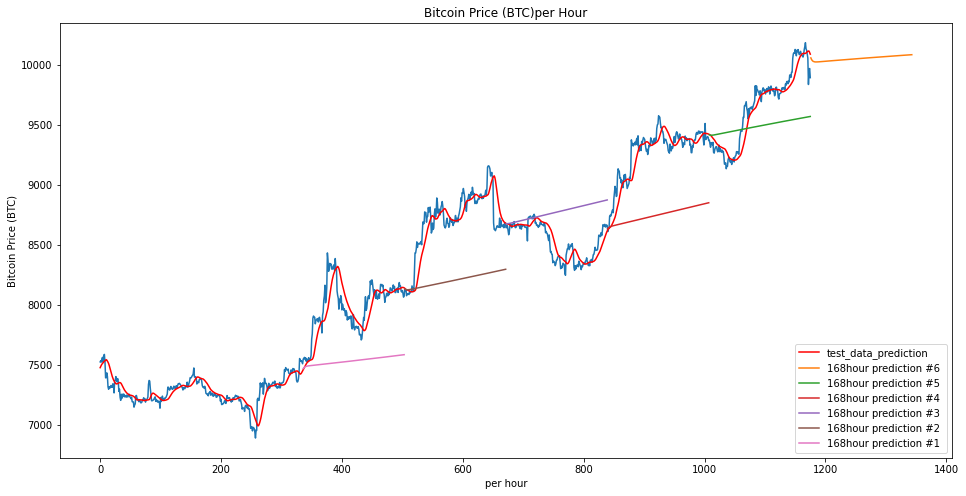

In [35]:
plt.figure(figsize = (16,8))
plt.plot(df2[len(df2)-lengthofperiod:])
plt.plot(test_predict[len(test_predict)-lengthofperiod:],color='r',label='test_data_prediction')
plt.plot(np.arange(1176,1344),final[0],label='168hour prediction #6 ')
plt.plot(np.arange(1008,1176),final[1],label='168hour prediction #5 ')
plt.plot(np.arange(840,1008),final[2],label='168hour prediction #4 ')
plt.plot(np.arange(672,840),final[3],label='168hour prediction #3 ')
plt.plot(np.arange(504,672),final[4],label='168hour prediction #2 ')
plt.plot(np.arange(336,504),final[5],label='168hour prediction #1 ')

plt.legend(loc='lower right',prop={'size': 10})
plt.xlabel('per hour')
plt.ylabel('Bitcoin Price (BTC)')
plt.title('Bitcoin Price (BTC)per Hour');